In [ ]:
!pip install multimodal-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 884 kB 5.3 MB/s 
     |████████████████████████████████| 3.0 MB 71.5 MB/s 
     |████████████████████████████████| 880 kB 73.9 MB/s 
     |████████████████████████████████| 1.2 MB 69.8 MB/s 
  Created wheel for multimodal-transformers: filename=multimodal_transformers-0.1.4a0-py3-none-any.whl size=20631 sha256=66a1a7e9078418e6e59e128c4282c1f5d39e1f981e511fca56b93a299f5f2a88
  Stored in directory: /root/.cache/pip/wheels/98/7d/6d/4398271d9112fbed70c0b1ddb6af3ccc25beddc9d7d5d625a1
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=33d44654341a77f5d8174b8489b5fa471adc3957215d7323c161da9646345afe
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built multimodal-transformers sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')
sys.path.append('tfm/inputs/')
sys.path.append('tfm/logs/')

Mounted at /content/drive


In [ ]:
import os
import shutil

shutil.rmtree('tfm/checkpoints/vola_paragraph7', ignore_errors=True) 
shutil.rmtree('tfm/logs/vola_paragraph7', ignore_errors=True) 
shutil.rmtree('tfm/checkpoints/vola_paragraph7/trained_model', ignore_errors=True)

os.mkdir('tfm/checkpoints/vola_paragraph7')
os.mkdir('tfm/logs/vola_paragraph7')
os.mkdir('tfm/checkpoints/vola_paragraph7/trained_model')

In [ ]:
import json
from dataclasses import dataclass, field
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multimodal_transformers.data import load_data
from multimodal_transformers.model import BertWithTabular, TabularConfig
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from transformers import BertConfig, BertTokenizer, EvalPrediction, Trainer
from transformers.training_args import TrainingArguments

In [ ]:
# filepath_topic_news = "../../data/outputs/dataset_20210101_20210110_paragraph_predict_topic_tag_news"
# filepath_finanzas = "../../data/outputs/dataset_20210101_20210110_paragraph_predict_finanzas_tag_s_n"
# filepath_impacto = "../../data/outputs/dataset_20210101_20210110_paragraph_predict_impacto_tag_s_n"
# filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_news_total_no"

In [ ]:
labeled_df = pd.read_csv(f"{filepath}_filters.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False, lineterminator="\n")
labeled_df.shape

(241553, 42)

In [ ]:
labeled_df.sort_values(by=["date"], inplace=True)

In [ ]:
# labeled_df = labeled_df.iloc[:int(labeled_df.shape[0]/2), :]

In [ ]:
# labeled_df.sort_values(by=["date"], inplace=True)

In [ ]:
labeled_df.shape

(241553, 42)

In [ ]:
# Se excluye topic_classifier debido al gran número de etiquetas:
labeled_df.topic_classifier.unique().shape

(1564,)

In [ ]:
labeled_df.finanzas_tag_s_proba.describe()

count    241551.000000
mean          0.207312
std           0.200667
min           0.001001
25%           0.040703
50%           0.136108
75%           0.320792
max           0.988306
Name: finanzas_tag_s_proba, dtype: float64

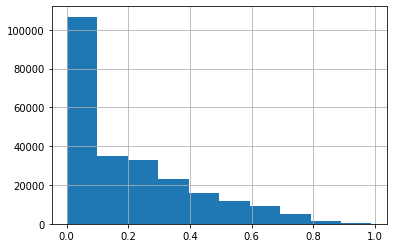

In [ ]:
labeled_df.finanzas_tag_s_proba.hist()

In [ ]:
labeled_df = labeled_df[(labeled_df.finanzas_tag_s_proba>=0.045)&(labeled_df.impacto_tag_s_proba>=0.15)]

In [ ]:
labeled_df.shape

(156140, 42)

In [ ]:
labeled_df.impacto_tag_s_proba.describe()

count    156140.000000
mean          0.345730
std           0.121607
min           0.150002
25%           0.254161
50%           0.327005
75%           0.421857
max           0.887281
Name: impacto_tag_s_proba, dtype: float64

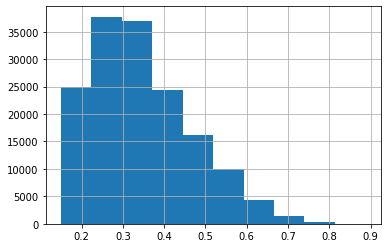

In [ ]:
labeled_df.impacto_tag_s_proba.hist()

In [ ]:
# labeled_df = labeled_df[labeled_df.finanzas_tag_s_proba > 0.5]
# labeled_df = labeled_df[labeled_df.intensidad > 2]

In [ ]:
# labeled_df.shape

In [ ]:
labeled_df.vola_label.value_counts()/labeled_df.vola_label.count()
# labeled_df.vola_label_abs.value_counts()/labeled_df.vola_label_abs.count()

 1.0    0.398258
-1.0    0.305457
 0.0    0.296285
Name: vola_label, dtype: float64

In [ ]:
labeled_df.columns.to_list()

['date',
 'title',
 'url',
 'body',
 'tags',
 'resource',
 'ticker',
 'ticker_name',
 'sector',
 'subsector',
 'ticker_freq',
 'ticker_first',
 'ticker_title',
 'tickers',
 'entities',
 'topic_classifier',
 'topics',
 'finanzas_prob',
 'sector_in_topics',
 'intensidad',
 'rd_activo_news',
 'rd_bench_news',
 'alpha_exante',
 'alpha_exante_Q1',
 'alpha_exante_below_Q1',
 'alpha_exante_Q3',
 'alpha_exante_above_Q3',
 'vola20_exante',
 'vola20_expost',
 'vola20_antepost_pct_change',
 'vola20_umbral_Q1',
 'vola20_umbral_abs_Q1',
 'vola20_umbral_Q3',
 'vola20_umbral_abs_Q3',
 'vola_label',
 'vola_label_abs',
 'body_no_entities',
 'title_no_entities',
 'impacto_tag_s_n',
 'impacto_tag_s_proba',
 'finanzas_tag_s_n',
 'finanzas_tag_s_proba']

In [ ]:
include_cols = [
 'date', # antes del entrenamiento se elimina
#  'title',
#  'url',
#  'body',
#  'tags',
 'resource', # antes del entrenamiento se elimina
 'ticker', # antes del entrenamiento se elimina
#  'ticker_name',
 'sector',
#  'subsector',
 'ticker_freq',
 'ticker_first',
 'ticker_title',
#  'tickers',
#  'entities',
#  'topic_classifier',
#  'topics',
#  'finanzas_prob',
 'sector_in_topics',
#  'intensidad',
#  'rd_activo_news',
#  'rd_bench_news',
#  'alpha_exante',
#  'alpha_exante_Q1',
#  'alpha_exante_below_Q1',
#  'alpha_exante_Q3',
#  'alpha_exante_above_Q3',
 'vola20_exante',
#  'vola20_expost',
#  'vola20_antepost_pct_change',
#  'vola20_umbral_Q1',
#  'vola20_umbral_abs_Q1',
#  'vola20_umbral_Q3',
#  'vola20_umbral_abs_Q3',
  'vola_label',
  # 'vola_label_abs',
 'body_no_entities',
#  'title_no_entities',
#  'impacto_tag_s_n',
 'impacto_tag_s_proba',
#  'finanzas_tag_s_n',
 'finanzas_tag_s_proba'
 ]

In [ ]:
print(labeled_df.shape)
labeled_df = labeled_df.loc[:,include_cols]
print(labeled_df.shape)
labeled_df.dropna(inplace=True)
print(labeled_df.shape)

(156140, 42)
(156140, 13)
(156140, 13)


In [ ]:
# labeled_df.topic_tag_news = labeled_df.topic_tag_news.replace(topics_equivalence)

In [ ]:
labeled_df.columns.to_list()

['date',
 'resource',
 'ticker',
 'sector',
 'ticker_freq',
 'ticker_first',
 'ticker_title',
 'sector_in_topics',
 'vola20_exante',
 'vola_label',
 'body_no_entities',
 'impacto_tag_s_proba',
 'finanzas_tag_s_proba']

In [ ]:
convert_types = {
#  'alpha_exante': 'float64',
#  'alpha_exante_Q1': 'float64',
#  'alpha_exante_Q3': 'float64',
#  'alpha_exante_above_Q3': 'bool',
#  'alpha_exante_below_Q1': 'bool',
 'body_no_entities': 'object',
 'date': 'datetime64[ns]',
#  'finanzas_prob': 'float64',
 'finanzas_tag_s_proba': 'float64',
 'impacto_tag_s_proba': 'float64',
 'sector': 'object',
 'sector_in_topics': 'bool',
 'ticker_first': 'bool',
 'ticker_freq': 'int64',
 'ticker_title': 'bool',
 'vola20_exante': 'float64',
 'vola_label': 'int8'
  # 'vola_label_abs': 'int8'
 }

In [ ]:
to_standardize = [
#  'date',
#  'sector',
 'ticker_freq',
#  'ticker_first',
#  'ticker_title',
#  'finanzas_prob',
#  'sector_in_topics',
#  'alpha_exante',
#  'alpha_exante_Q1',
#  'alpha_exante_below_Q1',
#  'alpha_exante_Q3',
#  'alpha_exante_above_Q3',
 'vola20_exante',
#  'vola_label',
#  'body_no_entities',
#  'impacto_tag_s_proba',
#  'finanzas_tag_s_proba'
 ]

In [ ]:
labeled_df = labeled_df.astype(convert_types)

In [ ]:
# Generando las las dummies:
labeled_df = pd.get_dummies(labeled_df, columns=["sector"], drop_first=True, dtype="bool")

In [ ]:
labeled_df.vola_label = labeled_df.vola_label + 1

In [ ]:
labeled_df.vola_label.unique()

array([0, 2, 1], dtype=int8)

In [ ]:
labeled_df.dtypes

date                                            datetime64[ns]
resource                                                object
ticker                                                  object
ticker_freq                                              int64
ticker_first                                              bool
ticker_title                                              bool
sector_in_topics                                          bool
vola20_exante                                          float64
vola_label                                                int8
body_no_entities                                        object
impacto_tag_s_proba                                    float64
finanzas_tag_s_proba                                   float64
sector_Mat.Basicos, Industria y Construcción              bool
sector_Petróleo y Energía                                 bool
sector_Servicios Financieros                              bool
sector_Servicios Inmobiliarios                         

In [ ]:
#Revisar KFold con el movimiento del train split
features = labeled_df.copy()

In [ ]:
# Separando los datos de train con los de validación y test con un mes de tiempo
threshold_train = int(labeled_df.shape[0]*0.8)
paragraphs_month = labeled_df.resample("M", on="date").body_no_entities.count()
mask = paragraphs_month.cumsum() < threshold_train
train_split = paragraphs_month.cumsum()[mask][-1]
val_split = paragraphs_month.cumsum()[~mask][0]
test_split = val_split + int((labeled_df.shape[0]-val_split)/2)
train = labeled_df.iloc[:train_split]
val = labeled_df.iloc[val_split:test_split]
test = labeled_df.iloc[test_split:]

In [ ]:
print(labeled_df.shape)
print(train.shape)
print(val.shape)
print(test.shape)

(156140, 18)
(124310, 18)
(14660, 18)
(14660, 18)


In [ ]:
train['date_agg'] = train.date.dt.date
# #Nos quedamos con las noticias que han publicado solamente 1 vez en el dia en el mismo media para un ticker para evitar noticias contradictorias
df_grpby = train.groupby(['date_agg','ticker','resource'])
df_agg = df_grpby.agg({'ticker':'count'})
df_agg = df_agg[df_agg.ticker==1]
train = pd.merge(train, df_agg,  how='inner', left_on=['date_agg','ticker','resource'], right_index=True)
train.drop('ticker_x', axis=1, inplace=True)
train.drop('date_agg', axis=1, inplace=True)
train.drop('ticker_y', axis=1, inplace=True)
train.drop(["date", "ticker","resource"], axis=1, inplace=True)
val.drop(["date", "ticker","resource"], axis=1, inplace=True)
test.drop(["date", "ticker","resource"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train.vola_label.value_counts()/train.vola_label.count()

2    0.401581
1    0.310182
0    0.288237
Name: vola_label, dtype: float64

In [ ]:
ss = StandardScaler()

In [ ]:
train[to_standardize] = ss.fit_transform(train[to_standardize])

In [ ]:
val[to_standardize] = ss.transform(val[to_standardize])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
test[to_standardize] = ss.transform(test[to_standardize])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Probar en cambiar el combine_feat_method de acuerdo con las siguientes modalidades:
https://multimodal-toolkit.readthedocs.io/en/latest/notes/combine_methods.html

In [ ]:
@dataclass
class ModelArguments:
  """
  Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
  """

  model_name_or_path: str = field(
      metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
  )
  config_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
  )
  tokenizer_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
  )
  cache_dir: Optional[str] = field(
      default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
  )

@dataclass
class MultimodalDataTrainingArguments:
  """
  Arguments pertaining to how we combine tabular features
  Using `HfArgumentParser` we can turn this class
  into argparse arguments to be able to specify them on
  the command line.
  """

  data_path: str = field(metadata={
                            'help': 'the path to the csv file containing the dataset'
                        })
  column_info_path: str = field(
      default=None,
      metadata={
          'help': 'the path to the json file detailing which columns are text, categorical, numerical, and the label'
  })

  column_info: dict = field(
      default=None,
      metadata={
          'help': 'a dict referencing the text, categorical, numerical, and label columns'
                  'its keys are text_cols, num_cols, cat_cols, and label_col'
  })

  categorical_encode_type: str = field(default='ohe',
                                        metadata={
                                            'help': 'sklearn encoder to use for categorical data',
                                            'choices': ['ohe', 'binary', 'label', 'none']
                                        })
  numerical_transformer_method: str = field(default='yeo_johnson',
                                            metadata={
                                                'help': 'sklearn numerical transformer to preprocess numerical data',
                                                'choices': ['yeo_johnson', 'box_cox', 'quantile_normal', 'none']
                                            })
  task: str = field(default="classification",
                    metadata={
                        "help": "The downstream training task",
                        "choices": ["classification", "regression"]
                    })

  mlp_division: int = field(default=4,
                            metadata={
                                'help': 'the ratio of the number of '
                                        'hidden dims in a current layer to the next MLP layer'
                            })
  combine_feat_method: str = field(default='individual_mlps_on_cat_and_numerical_feats_then_concat',
                                    metadata={
                                        'help': 'method to combine categorical and numerical features, '
                                                'see README for all the method'
                                    })
  mlp_dropout: float = field(default=0.1,
                              metadata={
                                'help': 'dropout ratio used for MLP layers'
                              })
  numerical_bn: bool = field(default=True,
                              metadata={
                                  'help': 'whether to use batchnorm on numerical features'
                              })
  use_simple_classifier: str = field(default=True,
                                      metadata={
                                          'help': 'whether to use single layer or MLP as final classifier'
                                      })
  mlp_act: str = field(default='relu',
                        metadata={
                            'help': 'the activation function to use for finetuning layers',
                            'choices': ['relu', 'prelu', 'sigmoid', 'tanh', 'linear']
                        })
  gating_beta: float = field(default=0.2,
                              metadata={
                                  'help': "the beta hyperparameters used for gating tabular data "
                                          "see https://www.aclweb.org/anthology/2020.acl-main.214.pdf"
                              })

  def __post_init__(self):
      assert self.column_info != self.column_info_path
      if self.column_info is None and self.column_info_path:
          with open(self.column_info_path, 'r') as f:
              self.column_info = json.load(f)

In [ ]:
# N_EPOCAS = 10
N_EPOCAS = 6

In [ ]:
train.dtypes

ticker_freq                                     float64
ticker_first                                       bool
ticker_title                                       bool
sector_in_topics                                   bool
vola20_exante                                   float64
vola_label                                         int8
body_no_entities                                 object
impacto_tag_s_proba                             float64
finanzas_tag_s_proba                            float64
sector_Mat.Basicos, Industria y Construcción       bool
sector_Petróleo y Energía                          bool
sector_Servicios Financieros                       bool
sector_Servicios Inmobiliarios                     bool
sector_Servicios de Consumo                        bool
sector_Tecnología y Telecomunicaciones             bool
dtype: object

In [ ]:
labeled_df.dtypes[labeled_df.dtypes == 'float64'].index.to_list()

['vola20_exante', 'impacto_tag_s_proba', 'finanzas_tag_s_proba']

In [ ]:
text_cols = train.dtypes[train.dtypes == 'object'].index.to_list()
cat_cols = train.dtypes[train.dtypes == 'bool'].index.to_list()
numerical_cols = train.dtypes[train.dtypes == 'float64'].index.to_list()

column_info_dict = {
    'text_cols': text_cols,
    'num_cols': numerical_cols,
    'cat_cols': cat_cols,
    'label_col': train.dtypes[train.dtypes == 'int8'].index.to_list()[0]
}


model_args = ModelArguments(
    model_name_or_path='dccuchile/bert-base-spanish-wwm-uncased'
)

data_args = MultimodalDataTrainingArguments(
    data_path='tfm/inputs',
    combine_feat_method='gating_on_cat_and_num_feats_then_sum',
    column_info=column_info_dict,
    task='classification',
    categorical_encode_type='none',
    numerical_transformer_method='none',
    numerical_bn=False
)

training_args = TrainingArguments(
    # output_dir="./checkpoints/vola_paragraph",
    # logging_dir="./logs/vola_paragraph",
    run_name="vola_paragraphs",
    output_dir="tfm/checkpoints/vola_paragraph7",
    logging_dir="tfm/logs/vola_paragraph7",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=20,
    num_train_epochs=N_EPOCAS,
    evaluate_during_training=True,
    logging_steps=250,
    eval_steps=1000,
    save_steps=500,
    save_total_limit=10,
    learning_rate=5e-5,
    seed=42
)

In [ ]:
data_args.column_info['num_cols']

['ticker_freq', 'vola20_exante', 'impacto_tag_s_proba', 'finanzas_tag_s_proba']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
# Get Datasets
# train_dataset, val_dataset, test_dataset = load_data_from_folder(
#     data_args.data_path,
#     data_args.column_info['text_cols'],
#     tokenizer,
#     label_col=data_args.column_info['label_col'],
#     categorical_cols=data_args.column_info['cat_cols'],
#     numerical_cols=data_args.column_info['num_cols'],
#     sep_text_token_str=tokenizer.sep_token,
#     max_token_length=512
# )

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

In [ ]:
train_dataset = load_data(
    train,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
val_dataset = load_data(
    val,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
test_dataset = load_data(
    test,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
bert_config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

tabular_config = TabularConfig(
        cat_feat_dim=train_dataset.cat_feats.shape[1],  # need to specify this
        numerical_feat_dim=train_dataset.numerical_feats.shape[1],  # need to specify this
        num_labels=len(np.unique(train_dataset.labels)),   # need to specify this, assuming our task is binary classification
        **vars(data_args)
)

bert_config.tabular_config = tabular_config

# Para cargar el modelo guardado:
# model = BertWithTabular.from_pretrained("tfm/checkpoints/vola_paragraph7/checkpoint-10000")
model = BertWithTabular.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', config=bert_config)

Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.weight', 'cla

In [ ]:
def calc_classification_metrics(p: EvalPrediction):
  pred_labels = np.argmax(p.predictions, axis=1)
  pred_scores = softmax(p.predictions, axis=1)[:, 1]
  labels = p.label_ids
  if len(np.unique(labels)) == 2:  # binary classification
      roc_auc_pred_score = roc_auc_score(labels, pred_scores)
      precisions, recalls, thresholds = precision_recall_curve(labels,
                                                                pred_scores)
      fscore = (2 * precisions * recalls) / (precisions + recalls)
      fscore[np.isnan(fscore)] = 0
      ix = np.argmax(fscore)
      threshold = thresholds[ix].item()
      pr_auc = auc(recalls, precisions)
      tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()
      result = {'roc_auc': roc_auc_pred_score,
                'threshold': threshold,
                'pr_auc': pr_auc,
                'recall': recalls[ix].item(),
                'precision': precisions[ix].item(), 'f1': fscore[ix].item(),
                'tn': tn.item(), 'fp': fp.item(), 'fn': fn.item(), 'tp': tp.item()
                }
  else:
      acc = (pred_labels == labels).mean()
      f1 = f1_score(y_true=labels, y_pred=pred_labels, average='micro')
      result = {
          "acc": acc,
          "f1": f1,
          "acc_and_f1": (acc + f1) / 2,
          "mcc": matthews_corrcoef(labels, pred_labels)
      }

  return result

In [ ]:
def calc_classification_metrics(p: EvalPrediction):
  pred_labels = np.argmax(p.predictions, axis=1)
  labels = p.label_ids
  acc = (pred_labels == labels).mean()
  result = {"acc": acc}
  return result

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_classification_metrics,
)

In [ ]:
training = trainer.train()

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.7919555053710937, 'learning_rate': 4.879436728395062e-05, 'epoch': 0.14467592592592593, 'step': 250}
{'loss': 0.7729855346679687, 'learning_rate': 4.7588734567901236e-05, 'epoch': 0.28935185185185186, 'step': 500}
{'loss': 0.7762657470703125, 'learning_rate': 4.6383101851851856e-05, 'epoch': 0.4340277777777778, 'step': 750}
{'loss': 0.75415283203125, 'learning_rate': 4.517746913580247e-05, 'epoch': 0.5787037037037037, 'step': 1000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7526794295356511, 'eval_acc': 0.6845839017735335, 'epoch': 0.5787037037037037, 'step': 1000}
{'loss': 0.750340576171875, 'learning_rate': 4.397183641975309e-05, 'epoch': 0.7233796296296297, 'step': 1250}
{'loss': 0.75412744140625, 'learning_rate': 4.27662037037037e-05, 'epoch': 0.8680555555555556, 'step': 1500}


Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.736169921875, 'learning_rate': 4.156057098765432e-05, 'epoch': 1.0127314814814814, 'step': 1750}
{'loss': 0.76909423828125, 'learning_rate': 4.035493827160494e-05, 'epoch': 1.1574074074074074, 'step': 2000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7416950507996678, 'eval_acc': 0.6854024556616644, 'epoch': 1.1574074074074074, 'step': 2000}
{'loss': 0.749669921875, 'learning_rate': 3.914930555555556e-05, 'epoch': 1.3020833333333333, 'step': 2250}
{'loss': 0.758109375, 'learning_rate': 3.794367283950617e-05, 'epoch': 1.4467592592592593, 'step': 2500}
{'loss': 0.7462080078125, 'learning_rate': 3.673804012345679e-05, 'epoch': 1.5914351851851851, 'step': 2750}
{'loss': 0.743123046875, 'learning_rate': 3.553240740740741e-05, 'epoch': 1.7361111111111112, 'step': 3000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7506188267493801, 'eval_acc': 0.6839017735334243, 'epoch': 1.7361111111111112, 'step': 3000}
{'loss': 0.77417578125, 'learning_rate': 3.432677469135803e-05, 'epoch': 1.8807870370370372, 'step': 3250}


Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.7528740234375, 'learning_rate': 3.312114197530864e-05, 'epoch': 2.025462962962963, 'step': 3500}
{'loss': 0.7480107421875, 'learning_rate': 3.191550925925926e-05, 'epoch': 2.170138888888889, 'step': 3750}
{'loss': 0.7539072265625, 'learning_rate': 3.0709876543209876e-05, 'epoch': 2.314814814814815, 'step': 4000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7462612587465596, 'eval_acc': 0.685743519781719, 'epoch': 2.314814814814815, 'step': 4000}
{'loss': 0.7594677734375, 'learning_rate': 2.9504243827160493e-05, 'epoch': 2.459490740740741, 'step': 4250}
{'loss': 0.730595703125, 'learning_rate': 2.8298611111111113e-05, 'epoch': 2.6041666666666665, 'step': 4500}
{'loss': 0.749419921875, 'learning_rate': 2.709297839506173e-05, 'epoch': 2.7488425925925926, 'step': 4750}
{'loss': 0.7541533203125, 'learning_rate': 2.588734567901235e-05, 'epoch': 2.8935185185185186, 'step': 5000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7561355192453116, 'eval_acc': 0.6840381991814461, 'epoch': 2.8935185185185186, 'step': 5000}


Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.750828125, 'learning_rate': 2.4681712962962963e-05, 'epoch': 3.0381944444444446, 'step': 5250}
{'loss': 0.756814453125, 'learning_rate': 2.3476080246913583e-05, 'epoch': 3.1828703703703702, 'step': 5500}
{'loss': 0.747029296875, 'learning_rate': 2.22704475308642e-05, 'epoch': 3.3275462962962963, 'step': 5750}
{'loss': 0.749708984375, 'learning_rate': 2.1064814814814816e-05, 'epoch': 3.4722222222222223, 'step': 6000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7478780282633366, 'eval_acc': 0.6847885402455661, 'epoch': 3.4722222222222223, 'step': 6000}
{'loss': 0.756779296875, 'learning_rate': 1.9859182098765433e-05, 'epoch': 3.616898148148148, 'step': 6250}
{'loss': 0.753099609375, 'learning_rate': 1.8653549382716053e-05, 'epoch': 3.761574074074074, 'step': 6500}
{'loss': 0.74304296875, 'learning_rate': 1.7447916666666666e-05, 'epoch': 3.90625, 'step': 6750}


Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.751296875, 'learning_rate': 1.6242283950617286e-05, 'epoch': 4.050925925925926, 'step': 7000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7427055423858221, 'eval_acc': 0.6850613915416098, 'epoch': 4.050925925925926, 'step': 7000}
{'loss': 0.74745703125, 'learning_rate': 1.5036651234567903e-05, 'epoch': 4.195601851851852, 'step': 7250}
{'loss': 0.751451171875, 'learning_rate': 1.3831018518518518e-05, 'epoch': 4.340277777777778, 'step': 7500}
{'loss': 0.745234375, 'learning_rate': 1.2625385802469136e-05, 'epoch': 4.484953703703704, 'step': 7750}
{'loss': 0.754013671875, 'learning_rate': 1.1419753086419753e-05, 'epoch': 4.62962962962963, 'step': 8000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7451496000504592, 'eval_acc': 0.6851296043656208, 'epoch': 4.62962962962963, 'step': 8000}
{'loss': 0.751087890625, 'learning_rate': 1.0214120370370371e-05, 'epoch': 4.774305555555555, 'step': 8250}
{'loss': 0.735966796875, 'learning_rate': 9.008487654320988e-06, 'epoch': 4.918981481481482, 'step': 8500}


Iteration:   0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 0.733603515625, 'learning_rate': 7.802854938271606e-06, 'epoch': 5.063657407407407, 'step': 8750}
{'loss': 0.752041015625, 'learning_rate': 6.597222222222223e-06, 'epoch': 5.208333333333333, 'step': 9000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7423723827198778, 'eval_acc': 0.6858117326057299, 'epoch': 5.208333333333333, 'step': 9000}
{'loss': 0.717224609375, 'learning_rate': 5.39158950617284e-06, 'epoch': 5.3530092592592595, 'step': 9250}
{'loss': 0.752212890625, 'learning_rate': 4.185956790123457e-06, 'epoch': 5.497685185185185, 'step': 9500}
{'loss': 0.7528359375, 'learning_rate': 2.9803240740740743e-06, 'epoch': 5.642361111111111, 'step': 9750}
{'loss': 0.741166015625, 'learning_rate': 1.7746913580246913e-06, 'epoch': 5.787037037037037, 'step': 10000}


Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7445706521749171, 'eval_acc': 0.6850613915416098, 'epoch': 5.787037037037037, 'step': 10000}
{'loss': 0.754873046875, 'learning_rate': 5.690586419753087e-07, 'epoch': 5.931712962962963, 'step': 10250}


In [ ]:
# evaluación sobre test
eva = trainer.evaluate(test_dataset)
eva

Evaluation:   0%|          | 0/1833 [00:00<?, ?it/s]

{'eval_loss': 0.7289798995238534, 'eval_acc': 0.6979536152796726, 'step': 0}


{'eval_acc': 0.6979536152796726, 'eval_loss': 0.7289798995238534}

In [ ]:
trainer.save_model("tfm/checkpoints/vola_paragraph7/trained_model")

In [ ]:
output_train=trainer.predict(train_dataset)

Prediction:   0%|          | 0/4318 [00:00<?, ?it/s]

In [ ]:
output_test=trainer.predict(test_dataset)

Prediction:   0%|          | 0/1833 [00:00<?, ?it/s]

In [ ]:
proba_train = tf.nn.softmax(output_train.predictions).numpy()

In [ ]:
proba_test = tf.nn.softmax(output_test.predictions).numpy()

In [ ]:
y_predictions_train = proba_train.argmax(axis=1)

In [ ]:
y_predictions_test = proba_test.argmax(axis=1)

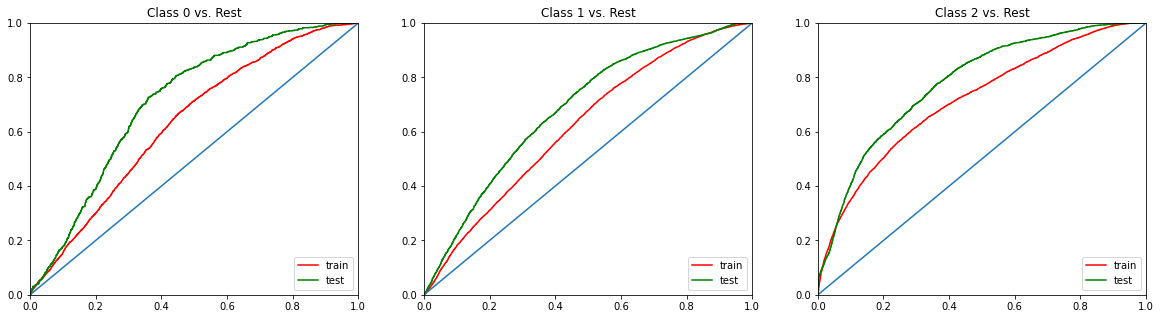

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    train_fpr, train_tpr, train_thr = roc_curve((train.vola_label.values == i).astype("int"), proba_train[:,i], pos_label=1)
    test_fpr, test_tpr, test_thr = roc_curve((test.vola_label.values == i).astype("int"), proba_test[:,i], pos_label=1)
    axis[i].set_title(f"Class {i} vs. Rest")
    axis[i].plot(train_fpr, train_tpr, color='r', label='train')
    axis[i].plot(test_fpr, test_tpr, color='g', label='test')
    axis[i].plot([0,1],[0,1])
    axis[i].axis(xmin=0.0,xmax=1.0, ymin=0.0, ymax=1.0)
    axis[i].legend(loc='lower right')
plt.show()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "tfm/logs/vola_paragraph7"

# FOLDS TIME SERIES SPLIT

In [ ]:
features

date     resource ticker  ticker_freq  \
pk                                                                           
1657038771539_11_BKIA 2017-03-12 08:00:00  EUROPAPRESS   BKIA            1   
1657039407908_11_ACS  2017-03-12 09:07:00       ELPAIS    ACS            4   
1657038752686_11_SAN  2017-03-12 10:21:00  EUROPAPRESS    SAN            1   
1657038727037_11_ABE  2017-03-12 11:12:00  EUROPAPRESS    ABE            4   
1657038727037_11_ACS  2017-03-12 11:12:00  EUROPAPRESS    ACS            4   
...                                   ...          ...    ...          ...   
1656541179736_6_BKT   2022-04-30 09:01:08    CINCODIAS    BKT            4   
1656541179736_6_BBVA  2022-04-30 09:01:08    CINCODIAS   BBVA            3   
1656541179736_6_ANA   2022-04-30 09:01:08    CINCODIAS    ANA            1   
1656541179736_6_ACX   2022-04-30 09:01:08    CINCODIAS    ACX            2   
1656541176337_6_GRF   2022-04-30 16:44:01    CINCODIAS    GRF            4   

                       ticker_first  ticker_title  sector_in_topics  \
pk                                                                    
1657038771539_11_BKIA         False         False             False   
1657039407908_11_ACS          False         False             False   
1657038752686_11_SAN          False         False              True   
1657038727037_11_ABE           True         False             False   
1657038727037_11_ACS          False         False             False   
...                             ...           ...               ...   
1656541179736_6_BKT           False         False             False   
1656541179736_6_BBVA          False         False             False   
1656541179736_6_ANA           False         False             False   
1656541179736_6_ACX            True         False             False   
1656541176337_6_GRF           False          True             False   

                       vola20_exante  vola_label  \
pk                                                 
1657038771539_11_BKIA       0.229366           0   
1657039407908_11_ACS        0.121329           2   
1657038752686_11_SAN        0.225347           1   
1657038727037_11_ABE        0.083359           2   
1657038727037_11_ACS        0.121329           2   
...                              ...         ...   
1656541179736_6_BKT         0.347486           2   
1656541179736_6_BBVA        0.378315           0   
1656541179736_6_ANA         0.243105           1   
1656541179736_6_ACX         0.336467           1   
1656541176337_6_GRF         0.456726           1   

                                                        body_no_entities  \
pk                                                                         
1657038771539_11_BKIA  El 'octubre negro' que se consumó en cifras ec...   
1657039407908_11_ACS   “Si he logrado ver más lejos, ha sido porque h...   
1657038752686_11_SAN   MADRID, 3 Dic. (EUROPA PRESS) - Los bonos de f...   
1657038727037_11_ABE   Renta 4 Banco apuesta por BME para sustituir a...   
1657038727037_11_ACS   Renta 4 Banco apuesta por BME para sustituir a...   
...                                                                  ...   
1656541179736_6_BKT    La Bolsa española ofrece este año algunas dosi...   
1656541179736_6_BBVA   La Bolsa española ofrece este año algunas dosi...   
1656541179736_6_ANA    La Bolsa española ofrece este año algunas dosi...   
1656541179736_6_ACX    La Bolsa española ofrece este año algunas dosi...   
1656541176337_6_GRF    ve dispararse su deuda, una partida que ya pre...   

                       impacto_tag_s_proba  finanzas_tag_s_proba  \
pk                                                                 
1657038771539_11_BKIA             0.256989              0.142221   
1657039407908_11_ACS              0.235983              0.134794   
1657038752686_11_SAN              0.293826              0.302902   
1657038727037_11_ABE              0.265241              0.286167   
1657038727037_11_ACS    

In [ ]:
features.reset_index(drop=True, inplace=True)
features.index = list(features.index)
features.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            156130, 156131, 156132, 156133, 156134, 156135, 156136, 156137,
            156138, 156139],
           dtype='int64', length=156140)

In [ ]:
features.resample(rule='M', on='date').size()

date
2017-03-31      32
2017-04-30    2177
2017-05-31    2582
2017-06-30    2645
2017-07-31    2471
              ... 
2021-12-31    2034
2022-01-31    2228
2022-02-28    2629
2022-03-31    2636
2022-04-30    1939
Freq: M, Length: 62, dtype: int64

In [ ]:
features.resample(rule='M', on='date').size().iloc[1:-3]

date
2017-04-30    2177
2017-05-31    2582
2017-06-30    2645
2017-07-31    2471
2017-08-31    1877
2017-09-30    2283
2017-10-31    3372
2017-11-30    2680
2017-12-31    2283
2018-01-31    2630
2018-02-28    2910
2018-03-31    2547
2018-04-30    2358
2018-05-31    2473
2018-06-30    2471
2018-07-31    2302
2018-08-31    2007
2018-09-30    2247
2018-10-31    2961
2018-11-30    2542
2018-12-31    2017
2019-01-31    2463
2019-02-28    2633
2019-03-31    2880
2019-04-30    2433
2019-05-31    2942
2019-06-30    2519
2019-07-31    2929
2019-08-31    2324
2019-09-30    2722
2019-10-31    2818
2019-11-30    2876
2019-12-31    2111
2020-01-31    2678
2020-02-29    2720
2020-03-31    3484
2020-04-30    2541
2020-05-31    2644
2020-06-30    2598
2020-07-31    2690
2020-08-31    1759
2020-09-30    2882
2020-10-31    2852
2020-11-30    3101
2020-12-31    2595
2021-01-31    2632
2021-02-28    2628
2021-03-31    2989
2021-04-30    2510
2021-05-31    2740
2021-06-30    2932
2021-07-31    2640
2021-08

In [ ]:
np.mean(features.resample(rule='M', on='date').size().iloc[1:-3])

2567.310344827586

In [ ]:
GAP = features.shape[0] / (12 * 5)
int(GAP)

2602

In [ ]:
N_SPLITS = 8 * 5

In [ ]:
import os

indir = 'tfm/inputs'
for x in range(N_SPLITS+1):
  if not os.path.exists(f"{indir}/{x}"):
    os.mkdir(f"{indir}/{x}")
  if not os.path.exists(f"tfm/checkpoints/vola_paragraph7/{x}"):
    os.mkdir(f"tfm/checkpoints/vola_paragraph7/{x}")
  if not os.path.exists(f"tfm/logs/vola_paragraph7/{x}"):
    os.mkdir(f"tfm/logs/vola_paragraph7/{x}")
  if not os.path.exists(f"tfm/checkpoints/vola_paragraph7/trained_model/{x}"):
    os.mkdir(f"tfm/checkpoints/vola_paragraph7/trained_model/{x}")

In [ ]:
#RuntimeError: CUDA out of memory. Tried to allocate 42.00 MiB (GPU 0; 15.90 GiB total capacity; 13.87 GiB already allocated; 29.75 MiB free; 14.83 GiB reserved in total by PyTorch) 
#If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
#Ejecutar en cada fold
import torch
torch.cuda.empty_cache()

TimeSeriesSplit(gap=2602, max_train_size=None, n_splits=40, test_size=None)
TRAIN dates: 2017-03-12 08:00:00 - 2017-04-19 07:55:42  TEST dates: 2017-05-19 14:42:00 - 2017-07-04 08:25:19
train_index.shape : (1218,) test_index.shape : (3808,)
TRAIN pre AGG shape : (1218, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (364, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.023530137412125, 'eval_acc': 0.47058823529411764, 'epoch': 6.0, 'step': 114}


Prediction:   0%|          | 0/46 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

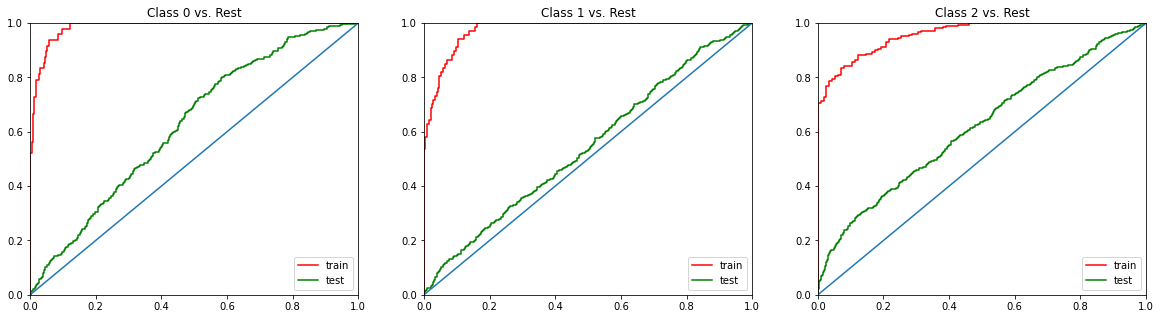

TRAIN dates: 2017-03-12 08:00:00 - 2017-06-04 09:59:00  TEST dates: 2017-07-04 08:25:19 - 2017-08-26 10:35:15
train_index.shape : (5026,) test_index.shape : (3808,)
TRAIN pre AGG shape : (5026, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (1279, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

{'loss': 0.7170462036132812, 'learning_rate': 1.7447916666666666e-05, 'epoch': 3.90625, 'step': 250}


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.515481103493386, 'eval_acc': 0.375, 'epoch': 6.0, 'step': 384}


Prediction:   0%|          | 0/160 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

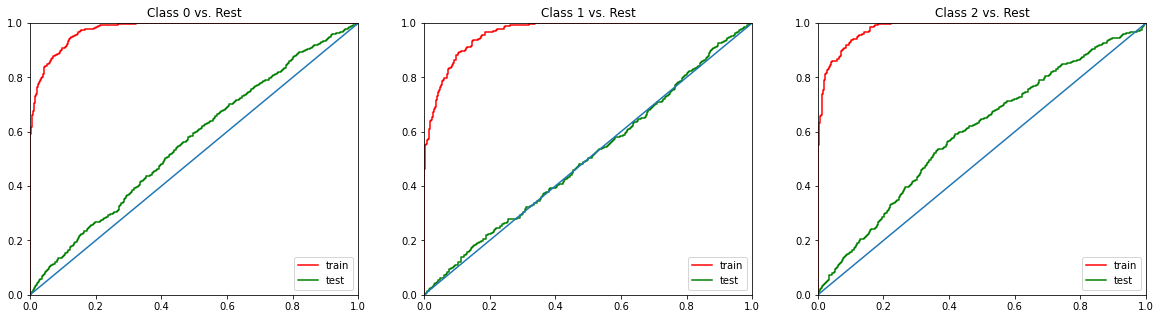

TRAIN dates: 2017-03-12 08:00:00 - 2017-07-20 17:39:00  TEST dates: 2017-08-26 10:35:15 - 2017-10-10 16:43:00
train_index.shape : (8834,) test_index.shape : (3808,)
TRAIN pre AGG shape : (8834, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (2172, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

{'loss': 0.6628159790039062, 'learning_rate': 3.08868501529052e-05, 'epoch': 2.293577981651376, 'step': 250}


Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

{'loss': 0.44538275146484374, 'learning_rate': 1.1773700305810397e-05, 'epoch': 4.587155963302752, 'step': 500}


Iteration:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.7539968216369133, 'eval_acc': 0.38130252100840334, 'epoch': 6.0, 'step': 654}


Prediction:   0%|          | 0/272 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

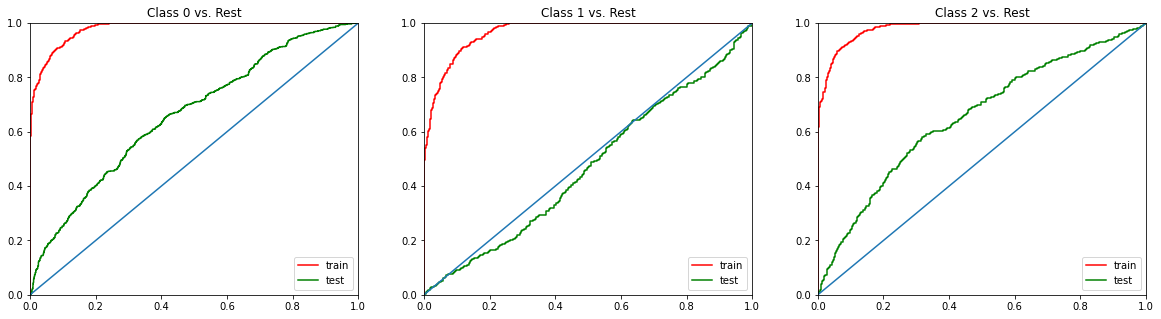

TRAIN dates: 2017-03-12 08:00:00 - 2017-09-12 16:51:23  TEST dates: 2017-10-10 16:44:44 - 2017-11-18 13:15:00
train_index.shape : (12642,) test_index.shape : (3808,)
TRAIN pre AGG shape : (12642, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (3236, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

{'loss': 0.678569580078125, 'learning_rate': 3.7139917695473254e-05, 'epoch': 1.5432098765432098, 'step': 250}


Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

{'loss': 0.53392333984375, 'learning_rate': 2.4279835390946505e-05, 'epoch': 3.0864197530864197, 'step': 500}


Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

{'loss': 0.4211695556640625, 'learning_rate': 1.1419753086419753e-05, 'epoch': 4.62962962962963, 'step': 750}


Iteration:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.9391549792485077, 'eval_acc': 0.4023109243697479, 'epoch': 6.0, 'step': 972}


Prediction:   0%|          | 0/405 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

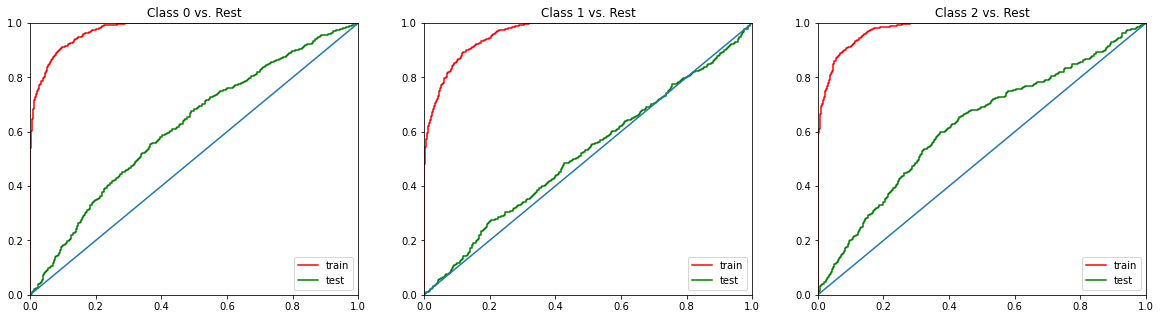

TRAIN dates: 2017-03-12 08:00:00 - 2017-10-23 11:14:00  TEST dates: 2017-11-18 16:26:51 - 2018-01-08 16:54:00
train_index.shape : (16450,) test_index.shape : (3808,)
TRAIN pre AGG shape : (16450, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (4136, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

{'loss': 0.621355224609375, 'learning_rate': 3.993558776167472e-05, 'epoch': 1.2077294685990339, 'step': 250}


Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

{'loss': 0.5053629150390625, 'learning_rate': 2.9871175523349438e-05, 'epoch': 2.4154589371980677, 'step': 500}


Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

{'loss': 0.4308870849609375, 'learning_rate': 1.9806763285024154e-05, 'epoch': 3.6231884057971016, 'step': 750}


Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

{'loss': 0.3911217041015625, 'learning_rate': 9.742351046698874e-06, 'epoch': 4.830917874396135, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.7406862192482007, 'eval_acc': 0.49054621848739494, 'epoch': 4.830917874396135, 'step': 1000}


Iteration:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.4773325782363154, 'eval_acc': 0.37342436974789917, 'epoch': 6.0, 'step': 1242}


Prediction:   0%|          | 0/517 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

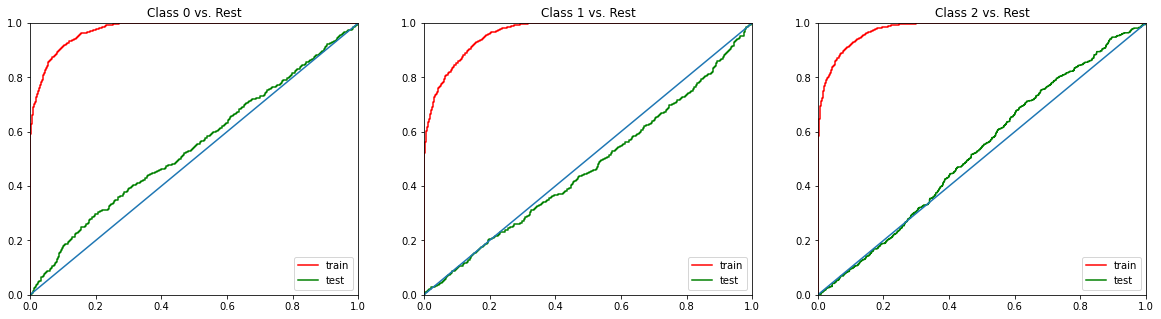

TRAIN dates: 2017-03-12 08:00:00 - 2017-12-04 08:24:00  TEST dates: 2018-01-08 17:19:22 - 2018-02-16 13:41:00
train_index.shape : (20258,) test_index.shape : (3808,)
TRAIN pre AGG shape : (20258, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (5032, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.6027008666992187, 'learning_rate': 4.173280423280423e-05, 'epoch': 0.9920634920634921, 'step': 250}


Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.4972987670898438, 'learning_rate': 3.3465608465608464e-05, 'epoch': 1.9841269841269842, 'step': 500}


Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.4349500732421875, 'learning_rate': 2.5198412698412697e-05, 'epoch': 2.9761904761904763, 'step': 750}


Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.4034105224609375, 'learning_rate': 1.693121693121693e-05, 'epoch': 3.9682539682539684, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.4966755497089328, 'eval_acc': 0.5241596638655462, 'epoch': 3.9682539682539684, 'step': 1000}


Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.3568594970703125, 'learning_rate': 8.664021164021165e-06, 'epoch': 4.9603174603174605, 'step': 1250}


Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.33427392578125, 'learning_rate': 3.9682539682539683e-07, 'epoch': 5.9523809523809526, 'step': 1500}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7315984666347504, 'eval_acc': 0.3744747899159664, 'epoch': 6.0, 'step': 1512}


Prediction:   0%|          | 0/629 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

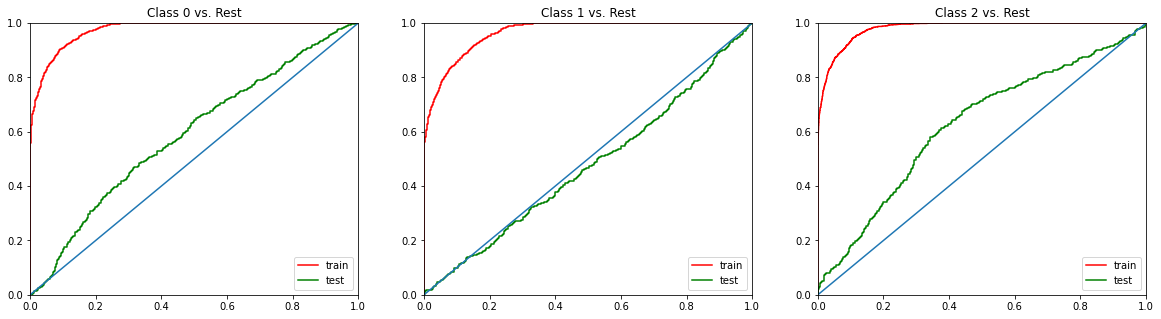

TRAIN dates: 2017-03-12 08:00:00 - 2018-01-22 09:18:00  TEST dates: 2018-02-16 13:41:00 - 2018-03-31 09:13:03
train_index.shape : (24066,) test_index.shape : (3808,)
TRAIN pre AGG shape : (24066, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (6136, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.61624951171875, 'learning_rate': 4.3213897937024975e-05, 'epoch': 0.8143322475570033, 'step': 250}


Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.527692138671875, 'learning_rate': 3.642779587404995e-05, 'epoch': 1.6286644951140063, 'step': 500}


Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.48501318359375, 'learning_rate': 2.9641693811074923e-05, 'epoch': 2.44299674267101, 'step': 750}


Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.44338525390625, 'learning_rate': 2.2855591748099893e-05, 'epoch': 3.257328990228013, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.1695372026507593, 'eval_acc': 0.36186974789915966, 'epoch': 3.257328990228013, 'step': 1000}


Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.407028076171875, 'learning_rate': 1.6069489685124865e-05, 'epoch': 4.071661237785016, 'step': 1250}
{'loss': 0.3756923828125, 'learning_rate': 9.283387622149838e-06, 'epoch': 4.88599348534202, 'step': 1500}


Iteration:   0%|          | 0/307 [00:00<?, ?it/s]

{'loss': 0.340840087890625, 'learning_rate': 2.4972855591748103e-06, 'epoch': 5.700325732899023, 'step': 1750}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.3155666028752044, 'eval_acc': 0.4012605042016807, 'epoch': 6.0, 'step': 1842}


Prediction:   0%|          | 0/767 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

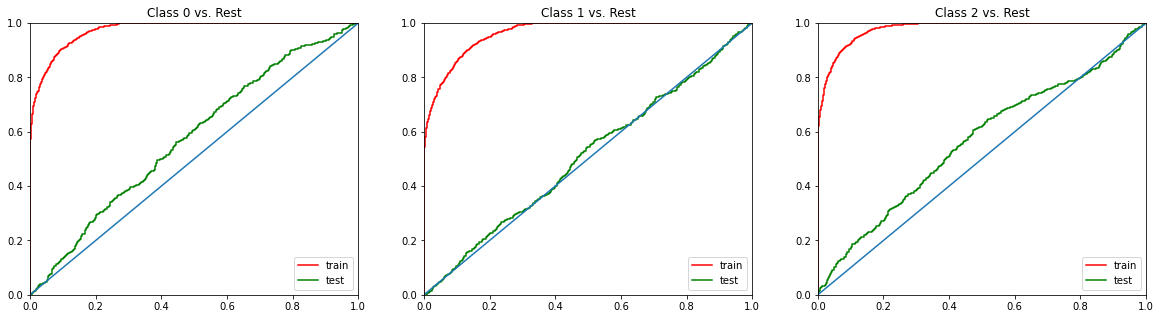

TRAIN dates: 2017-03-12 08:00:00 - 2018-02-28 18:14:00  TEST dates: 2018-03-31 09:13:03 - 2018-05-18 15:53:00
train_index.shape : (27874,) test_index.shape : (3808,)
TRAIN pre AGG shape : (27874, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (7051, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.5489375610351562, 'learning_rate': 4.409820585457979e-05, 'epoch': 0.7082152974504249, 'step': 250}


Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.4920165405273437, 'learning_rate': 3.819641170915959e-05, 'epoch': 1.41643059490085, 'step': 500}


Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.48061279296875, 'learning_rate': 3.229461756373938e-05, 'epoch': 2.1246458923512748, 'step': 750}
{'loss': 0.4253865966796875, 'learning_rate': 2.639282341831917e-05, 'epoch': 2.8328611898017, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.962625785660343, 'eval_acc': 0.37342436974789917, 'epoch': 2.8328611898017, 'step': 1000}


Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.3792403564453125, 'learning_rate': 2.0491029272898962e-05, 'epoch': 3.5410764872521248, 'step': 1250}


Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.388606201171875, 'learning_rate': 1.4589235127478753e-05, 'epoch': 4.2492917847025495, 'step': 1500}
{'loss': 0.360895751953125, 'learning_rate': 8.687440982058546e-06, 'epoch': 4.957507082152975, 'step': 1750}


Iteration:   0%|          | 0/353 [00:00<?, ?it/s]

{'loss': 0.314793212890625, 'learning_rate': 2.785646836638338e-06, 'epoch': 5.665722379603399, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7027890754847967, 'eval_acc': 0.3702731092436975, 'epoch': 5.665722379603399, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.7380510936373799, 'eval_acc': 0.5651260504201681, 'epoch': 6.0, 'step': 2118}


Prediction:   0%|          | 0/882 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

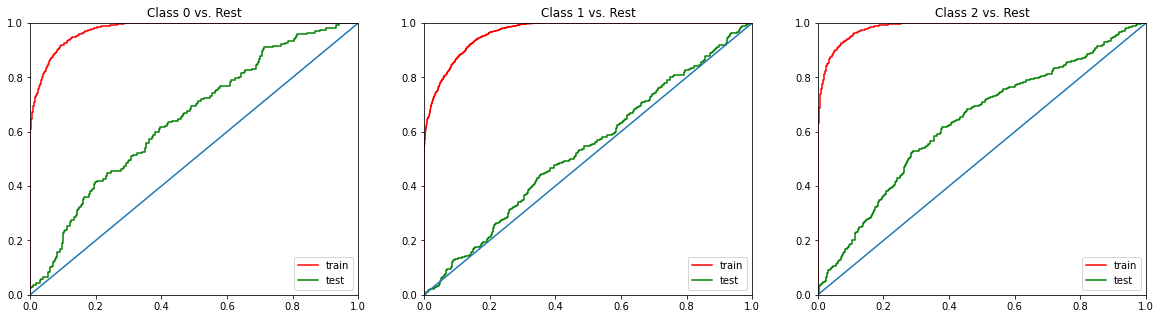

TRAIN dates: 2017-03-12 08:00:00 - 2018-04-16 18:11:00  TEST dates: 2018-05-18 15:53:00 - 2018-07-05 07:17:51
train_index.shape : (31682,) test_index.shape : (3808,)
TRAIN pre AGG shape : (31682, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (8071, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.5536882934570313, 'learning_rate': 4.4843234323432346e-05, 'epoch': 0.6188118811881188, 'step': 250}


Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.5432067260742187, 'learning_rate': 3.968646864686469e-05, 'epoch': 1.2376237623762376, 'step': 500}
{'loss': 0.4873641357421875, 'learning_rate': 3.452970297029703e-05, 'epoch': 1.8564356435643563, 'step': 750}


Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.4270028076171875, 'learning_rate': 2.9372937293729375e-05, 'epoch': 2.4752475247524752, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.8836937241193628, 'eval_acc': 0.44012605042016806, 'epoch': 2.4752475247524752, 'step': 1000}


Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.442199951171875, 'learning_rate': 2.4216171617161718e-05, 'epoch': 3.094059405940594, 'step': 1250}
{'loss': 0.397759033203125, 'learning_rate': 1.905940594059406e-05, 'epoch': 3.7128712871287126, 'step': 1500}


Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.3588701171875, 'learning_rate': 1.3902640264026403e-05, 'epoch': 4.3316831683168315, 'step': 1750}
{'loss': 0.35692626953125, 'learning_rate': 8.745874587458746e-06, 'epoch': 4.9504950495049505, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.763664279665266, 'eval_acc': 0.3130252100840336, 'epoch': 4.9504950495049505, 'step': 2000}


Iteration:   0%|          | 0/404 [00:00<?, ?it/s]

{'loss': 0.31541748046875, 'learning_rate': 3.589108910891089e-06, 'epoch': 5.569306930693069, 'step': 2250}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.5912250126359844, 'eval_acc': 0.3492647058823529, 'epoch': 6.0, 'step': 2424}


Prediction:   0%|          | 0/1009 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

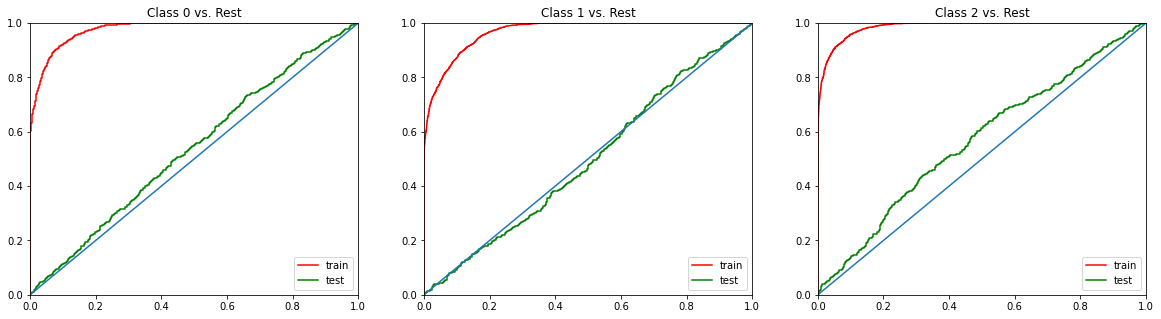

TRAIN dates: 2017-03-12 08:00:00 - 2018-06-04 07:22:35  TEST dates: 2018-07-05 07:18:53 - 2018-08-29 12:18:35
train_index.shape : (35490,) test_index.shape : (3808,)
TRAIN pre AGG shape : (35490, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (9136, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.5208302612304687, 'learning_rate': 4.5441283734500366e-05, 'epoch': 0.5470459518599562, 'step': 250}


Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.5152490844726563, 'learning_rate': 4.088256746900073e-05, 'epoch': 1.0940919037199124, 'step': 500}
{'loss': 0.450128173828125, 'learning_rate': 3.6323851203501094e-05, 'epoch': 1.6411378555798688, 'step': 750}


Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.4316385498046875, 'learning_rate': 3.1765134938001465e-05, 'epoch': 2.1881838074398248, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.9027731498750318, 'eval_acc': 0.41439075630252103, 'epoch': 2.1881838074398248, 'step': 1000}
{'loss': 0.4136263427734375, 'learning_rate': 2.7206418672501826e-05, 'epoch': 2.735229759299781, 'step': 1250}


Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.371115966796875, 'learning_rate': 2.264770240700219e-05, 'epoch': 3.2822757111597376, 'step': 1500}
{'loss': 0.378683837890625, 'learning_rate': 1.8088986141502554e-05, 'epoch': 3.8293216630196936, 'step': 1750}


Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.32386865234375, 'learning_rate': 1.353026987600292e-05, 'epoch': 4.3763676148796495, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.051041562838026, 'eval_acc': 0.42909663865546216, 'epoch': 4.3763676148796495, 'step': 2000}
{'loss': 0.3291884765625, 'learning_rate': 8.971553610503283e-06, 'epoch': 4.923413566739606, 'step': 2250}


Iteration:   0%|          | 0/457 [00:00<?, ?it/s]

{'loss': 0.30078662109375, 'learning_rate': 4.412837345003647e-06, 'epoch': 5.470459518599562, 'step': 2500}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.39979883064242, 'eval_acc': 0.4107142857142857, 'epoch': 6.0, 'step': 2742}


Prediction:   0%|          | 0/1142 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

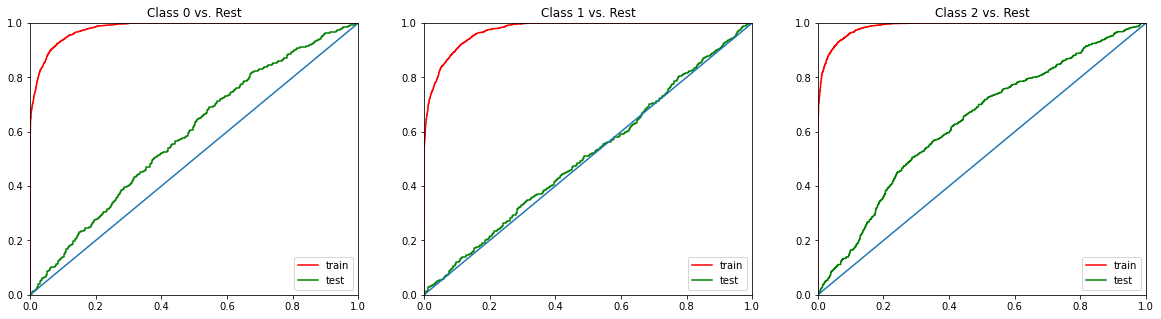

TRAIN dates: 2017-03-12 08:00:00 - 2018-07-23 11:38:00  TEST dates: 2018-08-29 12:18:35 - 2018-10-16 18:41:00
train_index.shape : (39298,) test_index.shape : (3808,)
TRAIN pre AGG shape : (39298, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (10237, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.49652456665039063, 'learning_rate': 4.593098958333334e-05, 'epoch': 0.48828125, 'step': 250}
{'loss': 0.5539754333496094, 'learning_rate': 4.186197916666667e-05, 'epoch': 0.9765625, 'step': 500}


Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.4513056640625, 'learning_rate': 3.7792968750000005e-05, 'epoch': 1.46484375, 'step': 750}
{'loss': 0.451493896484375, 'learning_rate': 3.372395833333333e-05, 'epoch': 1.953125, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.5891596308024991, 'eval_acc': 0.46008403361344535, 'epoch': 1.953125, 'step': 1000}


Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.38499072265625, 'learning_rate': 2.965494791666667e-05, 'epoch': 2.44140625, 'step': 1250}
{'loss': 0.392794677734375, 'learning_rate': 2.55859375e-05, 'epoch': 2.9296875, 'step': 1500}


Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.362547119140625, 'learning_rate': 2.1516927083333335e-05, 'epoch': 3.41796875, 'step': 1750}
{'loss': 0.355531982421875, 'learning_rate': 1.7447916666666666e-05, 'epoch': 3.90625, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.9837657866858636, 'eval_acc': 0.4690126050420168, 'epoch': 3.90625, 'step': 2000}


Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.3176708984375, 'learning_rate': 1.337890625e-05, 'epoch': 4.39453125, 'step': 2250}
{'loss': 0.319742431640625, 'learning_rate': 9.309895833333333e-06, 'epoch': 4.8828125, 'step': 2500}


Iteration:   0%|          | 0/512 [00:00<?, ?it/s]

{'loss': 0.302049560546875, 'learning_rate': 5.240885416666666e-06, 'epoch': 5.37109375, 'step': 2750}
{'loss': 0.29476904296875, 'learning_rate': 1.1718750000000001e-06, 'epoch': 5.859375, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.115062389178436, 'eval_acc': 0.4564075630252101, 'epoch': 5.859375, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.8224210047922216, 'eval_acc': 0.32983193277310924, 'epoch': 6.0, 'step': 3072}


Prediction:   0%|          | 0/1280 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

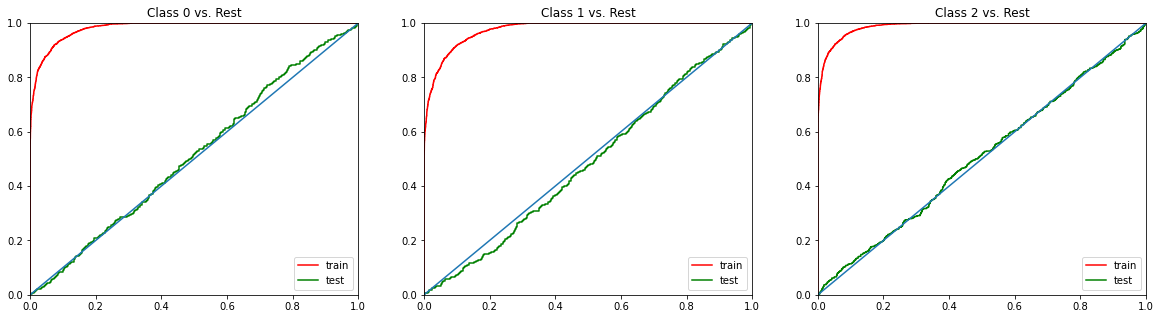

TRAIN dates: 2017-03-12 08:00:00 - 2018-09-13 18:02:10  TEST dates: 2018-10-16 18:41:00 - 2018-11-27 12:31:00
train_index.shape : (43106,) test_index.shape : (3808,)
TRAIN pre AGG shape : (43106, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (11297, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.4781875, 'learning_rate': 4.631268436578171e-05, 'epoch': 0.4424778761061947, 'step': 250}
{'loss': 0.513291748046875, 'learning_rate': 4.262536873156342e-05, 'epoch': 0.8849557522123894, 'step': 500}


Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.4489337158203125, 'learning_rate': 3.893805309734514e-05, 'epoch': 1.3274336283185841, 'step': 750}
{'loss': 0.437591552734375, 'learning_rate': 3.5250737463126844e-05, 'epoch': 1.7699115044247788, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.5400313887776447, 'eval_acc': 0.5084033613445378, 'epoch': 1.7699115044247788, 'step': 1000}


Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.3881087646484375, 'learning_rate': 3.156342182890856e-05, 'epoch': 2.2123893805309733, 'step': 1250}
{'loss': 0.383125, 'learning_rate': 2.7876106194690264e-05, 'epoch': 2.6548672566371683, 'step': 1500}


Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.39852197265625, 'learning_rate': 2.4188790560471978e-05, 'epoch': 3.0973451327433628, 'step': 1750}
{'loss': 0.3463837890625, 'learning_rate': 2.0501474926253688e-05, 'epoch': 3.5398230088495577, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.7303551201309477, 'eval_acc': 0.49789915966386555, 'epoch': 3.5398230088495577, 'step': 2000}
{'loss': 0.3523681640625, 'learning_rate': 1.6814159292035402e-05, 'epoch': 3.982300884955752, 'step': 2250}


Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.308555908203125, 'learning_rate': 1.3126843657817109e-05, 'epoch': 4.424778761061947, 'step': 2500}
{'loss': 0.325028564453125, 'learning_rate': 9.43952802359882e-06, 'epoch': 4.867256637168142, 'step': 2750}


Iteration:   0%|          | 0/565 [00:00<?, ?it/s]

{'loss': 0.27784033203125, 'learning_rate': 5.752212389380531e-06, 'epoch': 5.3097345132743365, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.237853437536905, 'eval_acc': 0.4217436974789916, 'epoch': 5.3097345132743365, 'step': 3000}
{'loss': 0.29480126953125, 'learning_rate': 2.064896755162242e-06, 'epoch': 5.752212389380531, 'step': 3250}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.194532894912888, 'eval_acc': 0.43592436974789917, 'epoch': 6.0, 'step': 3390}


Prediction:   0%|          | 0/1413 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

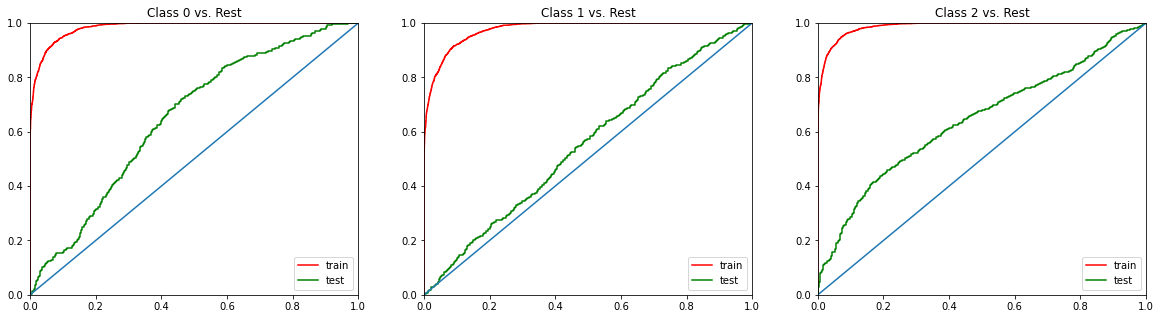

TRAIN dates: 2017-03-12 08:00:00 - 2018-10-29 08:25:00  TEST dates: 2018-11-27 12:31:00 - 2019-01-17 20:33:00
train_index.shape : (46914,) test_index.shape : (3808,)
TRAIN pre AGG shape : (46914, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (12253, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.4623901062011719, 'learning_rate': 4.660141381185427e-05, 'epoch': 0.4078303425774878, 'step': 250}
{'loss': 0.4944456481933594, 'learning_rate': 4.320282762370854e-05, 'epoch': 0.8156606851549756, 'step': 500}


Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.44158331298828124, 'learning_rate': 3.9804241435562806e-05, 'epoch': 1.2234910277324633, 'step': 750}
{'loss': 0.430231201171875, 'learning_rate': 3.640565524741708e-05, 'epoch': 1.631321370309951, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.099937042769264, 'eval_acc': 0.37237394957983194, 'epoch': 1.631321370309951, 'step': 1000}


Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.4389959716796875, 'learning_rate': 3.300706905927135e-05, 'epoch': 2.039151712887439, 'step': 1250}
{'loss': 0.3695927734375, 'learning_rate': 2.9608482871125614e-05, 'epoch': 2.4469820554649266, 'step': 1500}
{'loss': 0.3830537109375, 'learning_rate': 2.6209896682979884e-05, 'epoch': 2.8548123980424145, 'step': 1750}


Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.35681982421875, 'learning_rate': 2.281131049483415e-05, 'epoch': 3.262642740619902, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.119965047896409, 'eval_acc': 0.38760504201680673, 'epoch': 3.262642740619902, 'step': 2000}
{'loss': 0.337422119140625, 'learning_rate': 1.9412724306688418e-05, 'epoch': 3.6704730831973897, 'step': 2250}


Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.33544140625, 'learning_rate': 1.6014138118542688e-05, 'epoch': 4.078303425774878, 'step': 2500}
{'loss': 0.2993662109375, 'learning_rate': 1.2615551930396955e-05, 'epoch': 4.486133768352365, 'step': 2750}
{'loss': 0.31262158203125, 'learning_rate': 9.216965742251224e-06, 'epoch': 4.893964110929853, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.512485691604494, 'eval_acc': 0.3707983193277311, 'epoch': 4.893964110929853, 'step': 3000}


Iteration:   0%|          | 0/613 [00:00<?, ?it/s]

{'loss': 0.280083984375, 'learning_rate': 5.818379554105492e-06, 'epoch': 5.301794453507341, 'step': 3250}
{'loss': 0.27904541015625, 'learning_rate': 2.419793365959761e-06, 'epoch': 5.709624796084829, 'step': 3500}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.2622805913957227, 'eval_acc': 0.39810924369747897, 'epoch': 6.0, 'step': 3678}


Prediction:   0%|          | 0/1532 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

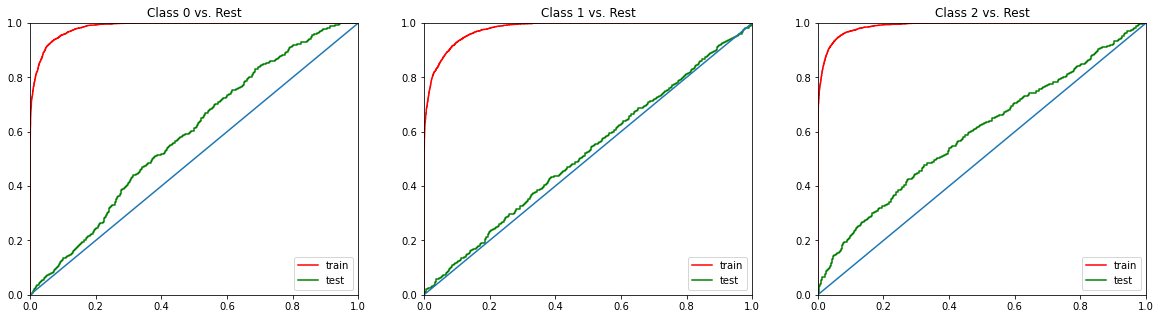

TRAIN dates: 2017-03-12 08:00:00 - 2018-12-12 21:35:36  TEST dates: 2019-01-17 20:33:00 - 2019-03-02 09:52:34
train_index.shape : (50722,) test_index.shape : (3808,)
TRAIN pre AGG shape : (50722, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (13166, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.4320299987792969, 'learning_rate': 4.683864441072332e-05, 'epoch': 0.37936267071320184, 'step': 250}
{'loss': 0.4702984924316406, 'learning_rate': 4.367728882144664e-05, 'epoch': 0.7587253414264037, 'step': 500}


Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.4595992431640625, 'learning_rate': 4.0515933232169955e-05, 'epoch': 1.1380880121396055, 'step': 750}
{'loss': 0.4051937255859375, 'learning_rate': 3.735457764289327e-05, 'epoch': 1.5174506828528074, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.6074277057367212, 'eval_acc': 0.47636554621848737, 'epoch': 1.5174506828528074, 'step': 1000}
{'loss': 0.4166658935546875, 'learning_rate': 3.419322205361659e-05, 'epoch': 1.8968133535660092, 'step': 1250}


Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.34680859375, 'learning_rate': 3.103186646433991e-05, 'epoch': 2.276176024279211, 'step': 1500}
{'loss': 0.3725390625, 'learning_rate': 2.7870510875063227e-05, 'epoch': 2.655538694992413, 'step': 1750}


Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.35948046875, 'learning_rate': 2.470915528578655e-05, 'epoch': 3.0349013657056148, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.222513423526284, 'eval_acc': 0.4380252100840336, 'epoch': 3.0349013657056148, 'step': 2000}
{'loss': 0.31178125, 'learning_rate': 2.1547799696509864e-05, 'epoch': 3.4142640364188166, 'step': 2250}
{'loss': 0.3315556640625, 'learning_rate': 1.8386444107233183e-05, 'epoch': 3.7936267071320184, 'step': 2500}


Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.314709716796875, 'learning_rate': 1.5225088517956502e-05, 'epoch': 4.17298937784522, 'step': 2750}
{'loss': 0.29027392578125, 'learning_rate': 1.2063732928679819e-05, 'epoch': 4.552352048558422, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.1953767548088265, 'eval_acc': 0.43539915966386555, 'epoch': 4.552352048558422, 'step': 3000}
{'loss': 0.29579296875, 'learning_rate': 8.902377339403137e-06, 'epoch': 4.931714719271624, 'step': 3250}


Iteration:   0%|          | 0/659 [00:00<?, ?it/s]

{'loss': 0.25967333984375, 'learning_rate': 5.7410217501264545e-06, 'epoch': 5.311077389984826, 'step': 3500}
{'loss': 0.2674296875, 'learning_rate': 2.5796661608497724e-06, 'epoch': 5.690440060698028, 'step': 3750}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7857513738279582, 'eval_acc': 0.3849789915966387, 'epoch': 6.0, 'step': 3954}


Prediction:   0%|          | 0/1646 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

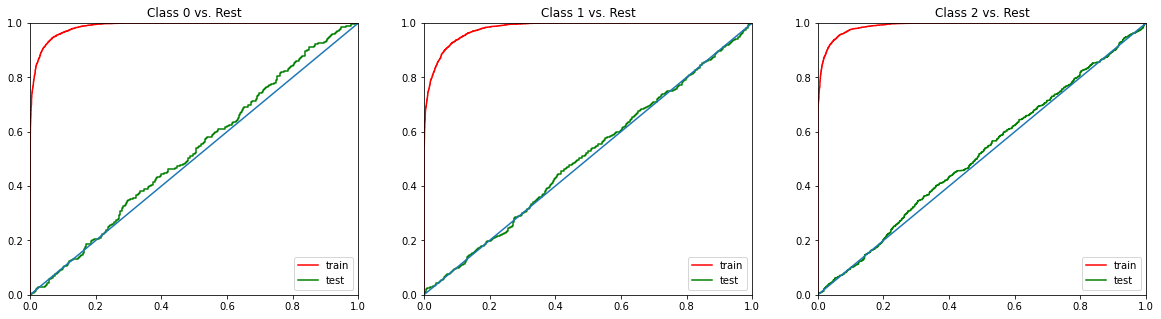

TRAIN dates: 2017-03-12 08:00:00 - 2019-02-04 11:57:31  TEST dates: 2019-03-02 09:52:34 - 2019-04-11 14:41:00
train_index.shape : (54530,) test_index.shape : (3808,)
TRAIN pre AGG shape : (54530, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (14364, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.44735955810546874, 'learning_rate': 4.7102457116365326e-05, 'epoch': 0.3477051460361613, 'step': 250}
{'loss': 0.463582275390625, 'learning_rate': 4.420491423273065e-05, 'epoch': 0.6954102920723226, 'step': 500}


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.47735968017578123, 'learning_rate': 4.130737134909597e-05, 'epoch': 1.043115438108484, 'step': 750}
{'loss': 0.358480712890625, 'learning_rate': 3.840982846546129e-05, 'epoch': 1.3908205841446453, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.1999078141290602, 'eval_acc': 0.37710084033613445, 'epoch': 1.3908205841446453, 'step': 1000}
{'loss': 0.412314208984375, 'learning_rate': 3.5512285581826614e-05, 'epoch': 1.7385257301808066, 'step': 1250}


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.394233154296875, 'learning_rate': 3.261474269819194e-05, 'epoch': 2.086230876216968, 'step': 1500}
{'loss': 0.36475927734375, 'learning_rate': 2.9717199814557255e-05, 'epoch': 2.433936022253129, 'step': 1750}
{'loss': 0.34373828125, 'learning_rate': 2.6819656930922575e-05, 'epoch': 2.7816411682892905, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.317555605613885, 'eval_acc': 0.375, 'epoch': 2.7816411682892905, 'step': 2000}


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.355021728515625, 'learning_rate': 2.39221140472879e-05, 'epoch': 3.129346314325452, 'step': 2250}
{'loss': 0.3105908203125, 'learning_rate': 2.1024571163653222e-05, 'epoch': 3.477051460361613, 'step': 2500}
{'loss': 0.318063232421875, 'learning_rate': 1.8127028280018546e-05, 'epoch': 3.8247566063977745, 'step': 2750}


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.29580908203125, 'learning_rate': 1.5229485396383866e-05, 'epoch': 4.172461752433936, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.607128958491718, 'eval_acc': 0.3697478991596639, 'epoch': 4.172461752433936, 'step': 3000}
{'loss': 0.27130908203125, 'learning_rate': 1.233194251274919e-05, 'epoch': 4.520166898470097, 'step': 3250}
{'loss': 0.2930048828125, 'learning_rate': 9.43439962911451e-06, 'epoch': 4.867872044506258, 'step': 3500}


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

{'loss': 0.272046875, 'learning_rate': 6.536856745479833e-06, 'epoch': 5.21557719054242, 'step': 3750}
{'loss': 0.24436328125, 'learning_rate': 3.6393138618451553e-06, 'epoch': 5.563282336578581, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.6743026780230656, 'eval_acc': 0.38287815126050423, 'epoch': 5.563282336578581, 'step': 4000}
{'loss': 0.25382568359375, 'learning_rate': 7.417709782104775e-07, 'epoch': 5.910987482614742, 'step': 4250}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.791769506801076, 'eval_acc': 0.3849789915966387, 'epoch': 6.0, 'step': 4314}


Prediction:   0%|          | 0/1796 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

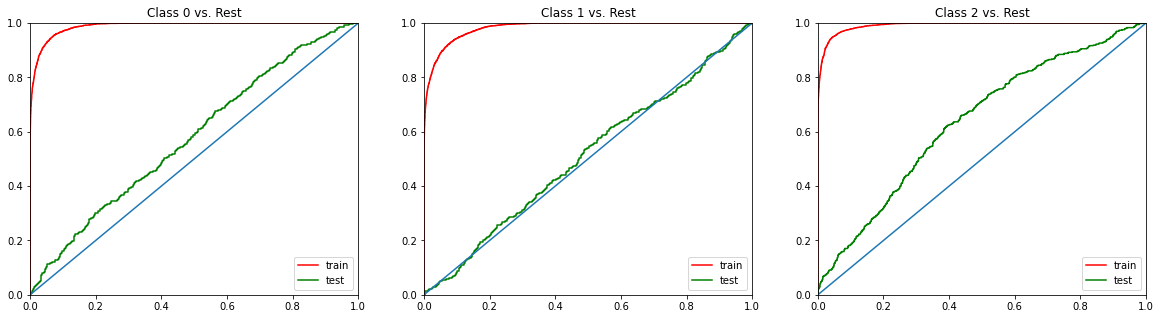

TRAIN dates: 2017-03-12 08:00:00 - 2019-03-15 02:24:01  TEST dates: 2019-04-11 14:41:00 - 2019-05-27 13:15:10
train_index.shape : (58338,) test_index.shape : (3808,)
TRAIN pre AGG shape : (58338, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (15361, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.41344790649414065, 'learning_rate': 4.729085392284352e-05, 'epoch': 0.3250975292587776, 'step': 250}
{'loss': 0.4531717224121094, 'learning_rate': 4.4581707845687045e-05, 'epoch': 0.6501950585175552, 'step': 500}
{'loss': 0.477270263671875, 'learning_rate': 4.187256176853056e-05, 'epoch': 0.9752925877763329, 'step': 750}


Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.3662861328125, 'learning_rate': 3.916341569137408e-05, 'epoch': 1.3003901170351106, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.224929828228069, 'eval_acc': 0.42857142857142855, 'epoch': 1.3003901170351106, 'step': 1000}
{'loss': 0.3925947265625, 'learning_rate': 3.64542696142176e-05, 'epoch': 1.6254876462938883, 'step': 1250}
{'loss': 0.414334716796875, 'learning_rate': 3.374512353706112e-05, 'epoch': 1.9505851755526658, 'step': 1500}


Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.328233642578125, 'learning_rate': 3.103597745990464e-05, 'epoch': 2.2756827048114436, 'step': 1750}
{'loss': 0.348058837890625, 'learning_rate': 2.832683138274816e-05, 'epoch': 2.6007802340702213, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.4757251589238143, 'eval_acc': 0.42909663865546216, 'epoch': 2.6007802340702213, 'step': 2000}
{'loss': 0.36019091796875, 'learning_rate': 2.5617685305591675e-05, 'epoch': 2.925877763328999, 'step': 2250}


Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.299141357421875, 'learning_rate': 2.29085392284352e-05, 'epoch': 3.250975292587776, 'step': 2500}
{'loss': 0.303298095703125, 'learning_rate': 2.0199393151278718e-05, 'epoch': 3.576072821846554, 'step': 2750}
{'loss': 0.32626708984375, 'learning_rate': 1.7490247074122236e-05, 'epoch': 3.9011703511053315, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.3252970641400634, 'eval_acc': 0.4322478991596639, 'epoch': 3.9011703511053315, 'step': 3000}


Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.2784794921875, 'learning_rate': 1.4781100996965758e-05, 'epoch': 4.22626788036411, 'step': 3250}
{'loss': 0.278931640625, 'learning_rate': 1.2071954919809276e-05, 'epoch': 4.551365409622887, 'step': 3500}
{'loss': 0.27019677734375, 'learning_rate': 9.362808842652797e-06, 'epoch': 4.876462938881664, 'step': 3750}


Iteration:   0%|          | 0/769 [00:00<?, ?it/s]

{'loss': 0.2490400390625, 'learning_rate': 6.653662765496315e-06, 'epoch': 5.201560468140442, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.5823354778044365, 'eval_acc': 0.43434873949579833, 'epoch': 5.201560468140442, 'step': 4000}
{'loss': 0.2326640625, 'learning_rate': 3.944516688339835e-06, 'epoch': 5.526657997399219, 'step': 4250}
{'loss': 0.25186328125, 'learning_rate': 1.235370611183355e-06, 'epoch': 5.851755526657997, 'step': 4500}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7746506611339186, 'eval_acc': 0.37762605042016806, 'epoch': 6.0, 'step': 4614}


Prediction:   0%|          | 0/1921 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

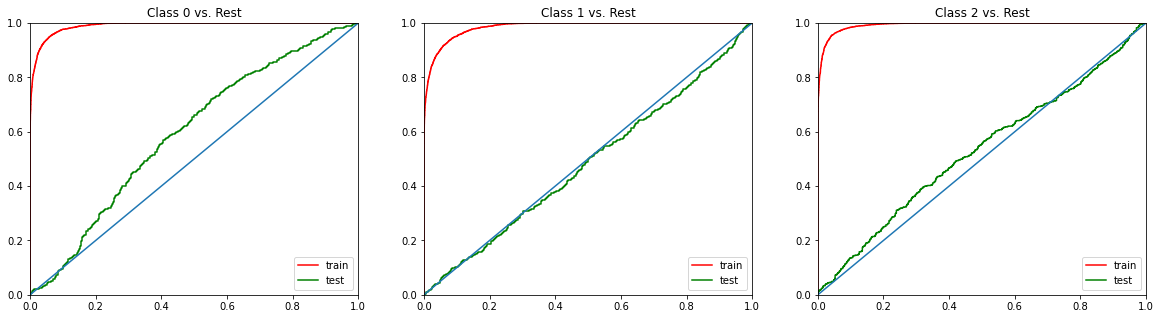

TRAIN dates: 2017-03-12 08:00:00 - 2019-04-30 07:44:18  TEST dates: 2019-05-27 13:29:00 - 2019-07-10 09:53:00
train_index.shape : (62146,) test_index.shape : (3808,)
TRAIN pre AGG shape : (62146, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (16509, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.41199822998046876, 'learning_rate': 4.7477804681194514e-05, 'epoch': 0.3026634382566586, 'step': 250}
{'loss': 0.4292650146484375, 'learning_rate': 4.4955609362389025e-05, 'epoch': 0.6053268765133172, 'step': 500}
{'loss': 0.45543341064453124, 'learning_rate': 4.2433414043583536e-05, 'epoch': 0.9079903147699758, 'step': 750}


Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.3892255859375, 'learning_rate': 3.991121872477805e-05, 'epoch': 1.2106537530266344, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.163557333104751, 'eval_acc': 0.3639705882352941, 'epoch': 1.2106537530266344, 'step': 1000}
{'loss': 0.3705855712890625, 'learning_rate': 3.7389023405972565e-05, 'epoch': 1.513317191283293, 'step': 1250}
{'loss': 0.38868603515625, 'learning_rate': 3.486682808716707e-05, 'epoch': 1.8159806295399514, 'step': 1500}


Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.376563720703125, 'learning_rate': 3.234463276836158e-05, 'epoch': 2.1186440677966103, 'step': 1750}
{'loss': 0.326613525390625, 'learning_rate': 2.9822437449556095e-05, 'epoch': 2.4213075060532687, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.428165997026347, 'eval_acc': 0.36239495798319327, 'epoch': 2.4213075060532687, 'step': 2000}
{'loss': 0.32852490234375, 'learning_rate': 2.730024213075061e-05, 'epoch': 2.7239709443099276, 'step': 2250}


Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.337453369140625, 'learning_rate': 2.4778046811945117e-05, 'epoch': 3.026634382566586, 'step': 2500}
{'loss': 0.284402099609375, 'learning_rate': 2.2255851493139628e-05, 'epoch': 3.3292978208232444, 'step': 2750}
{'loss': 0.30159716796875, 'learning_rate': 1.9733656174334143e-05, 'epoch': 3.6319612590799033, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.509565593064332, 'eval_acc': 0.36712184873949577, 'epoch': 3.6319612590799033, 'step': 3000}
{'loss': 0.29714404296875, 'learning_rate': 1.721146085552865e-05, 'epoch': 3.9346246973365617, 'step': 3250}


Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.26152294921875, 'learning_rate': 1.4689265536723165e-05, 'epoch': 4.237288135593221, 'step': 3500}
{'loss': 0.25459521484375, 'learning_rate': 1.2167070217917676e-05, 'epoch': 4.539951573849879, 'step': 3750}
{'loss': 0.2723935546875, 'learning_rate': 9.644874899112187e-06, 'epoch': 4.842615012106537, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7331015856451346, 'eval_acc': 0.3755252100840336, 'epoch': 4.842615012106537, 'step': 4000}


Iteration:   0%|          | 0/826 [00:00<?, ?it/s]

{'loss': 0.2495712890625, 'learning_rate': 7.122679580306698e-06, 'epoch': 5.145278450363196, 'step': 4250}
{'loss': 0.2236748046875, 'learning_rate': 4.600484261501211e-06, 'epoch': 5.447941888619855, 'step': 4500}
{'loss': 0.23167822265625, 'learning_rate': 2.0782889426957224e-06, 'epoch': 5.750605326876514, 'step': 4750}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.970912067704842, 'eval_acc': 0.3707983193277311, 'epoch': 6.0, 'step': 4956}


Prediction:   0%|          | 0/2064 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

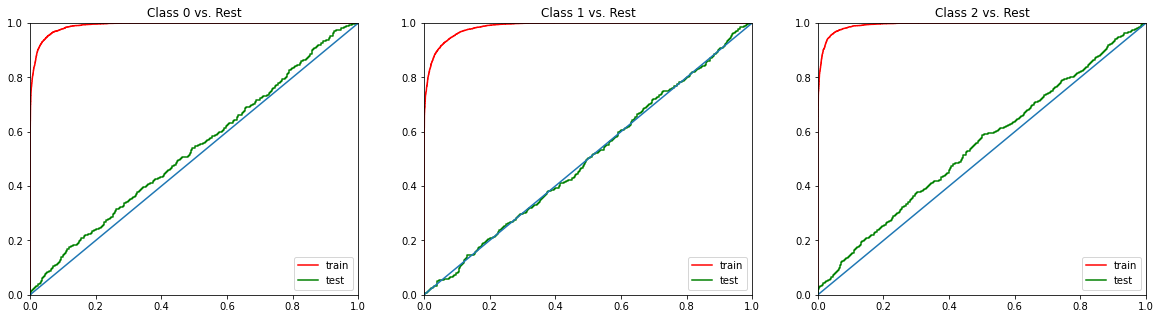

TRAIN dates: 2017-03-12 08:00:00 - 2019-06-10 13:26:00  TEST dates: 2019-07-10 10:47:30 - 2019-08-23 08:06:13
train_index.shape : (65954,) test_index.shape : (3808,)
TRAIN pre AGG shape : (65954, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

TRAIN shape : (17582, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/depr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.39401907348632814, 'learning_rate': 4.763257575757576e-05, 'epoch': 0.2840909090909091, 'step': 250}
{'loss': 0.4393086242675781, 'learning_rate': 4.5265151515151514e-05, 'epoch': 0.5681818181818182, 'step': 500}
{'loss': 0.43688031005859373, 'learning_rate': 4.289772727272727e-05, 'epoch': 0.8522727272727273, 'step': 750}


Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.4001629638671875, 'learning_rate': 4.053030303030303e-05, 'epoch': 1.1363636363636362, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.7349089267624527, 'eval_acc': 0.5021008403361344, 'epoch': 1.1363636363636362, 'step': 1000}
{'loss': 0.36259814453125, 'learning_rate': 3.816287878787879e-05, 'epoch': 1.4204545454545454, 'step': 1250}
{'loss': 0.3724364013671875, 'learning_rate': 3.579545454545455e-05, 'epoch': 1.7045454545454546, 'step': 1500}
{'loss': 0.388718017578125, 'learning_rate': 3.342803030303031e-05, 'epoch': 1.9886363636363638, 'step': 1750}


Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.301718017578125, 'learning_rate': 3.106060606060606e-05, 'epoch': 2.2727272727272725, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.9366411783521165, 'eval_acc': 0.4810924369747899, 'epoch': 2.2727272727272725, 'step': 2000}
{'loss': 0.31096630859375, 'learning_rate': 2.869318181818182e-05, 'epoch': 2.5568181818181817, 'step': 2250}
{'loss': 0.338391357421875, 'learning_rate': 2.6325757575757575e-05, 'epoch': 2.840909090909091, 'step': 2500}


Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.301654296875, 'learning_rate': 2.3958333333333334e-05, 'epoch': 3.125, 'step': 2750}
{'loss': 0.26833154296875, 'learning_rate': 2.1590909090909093e-05, 'epoch': 3.409090909090909, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.418414749455552, 'eval_acc': 0.4317226890756303, 'epoch': 3.409090909090909, 'step': 3000}
{'loss': 0.30584716796875, 'learning_rate': 1.922348484848485e-05, 'epoch': 3.6931818181818183, 'step': 3250}
{'loss': 0.28092236328125, 'learning_rate': 1.6856060606060605e-05, 'epoch': 3.9772727272727275, 'step': 3500}


Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.2384931640625, 'learning_rate': 1.4488636363636366e-05, 'epoch': 4.261363636363637, 'step': 3750}
{'loss': 0.246025390625, 'learning_rate': 1.2121212121212122e-05, 'epoch': 4.545454545454545, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.5117415531593212, 'eval_acc': 0.43592436974789917, 'epoch': 4.545454545454545, 'step': 4000}
{'loss': 0.2508818359375, 'learning_rate': 9.75378787878788e-06, 'epoch': 4.829545454545455, 'step': 4250}


Iteration:   0%|          | 0/880 [00:00<?, ?it/s]

{'loss': 0.24848388671875, 'learning_rate': 7.386363636363637e-06, 'epoch': 5.113636363636363, 'step': 4500}
{'loss': 0.20467626953125, 'learning_rate': 5.018939393939394e-06, 'epoch': 5.3977272727272725, 'step': 4750}
{'loss': 0.2208623046875, 'learning_rate': 2.651515151515152e-06, 'epoch': 5.681818181818182, 'step': 5000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.287080799581624, 'eval_acc': 0.47689075630252103, 'epoch': 5.681818181818182, 'step': 5000}
{'loss': 0.2349033203125, 'learning_rate': 2.840909090909091e-07, 'epoch': 5.965909090909091, 'step': 5250}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.8605555166967775, 'eval_acc': 0.37710084033613445, 'epoch': 6.0, 'step': 5280}


Prediction:   0%|          | 0/2198 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

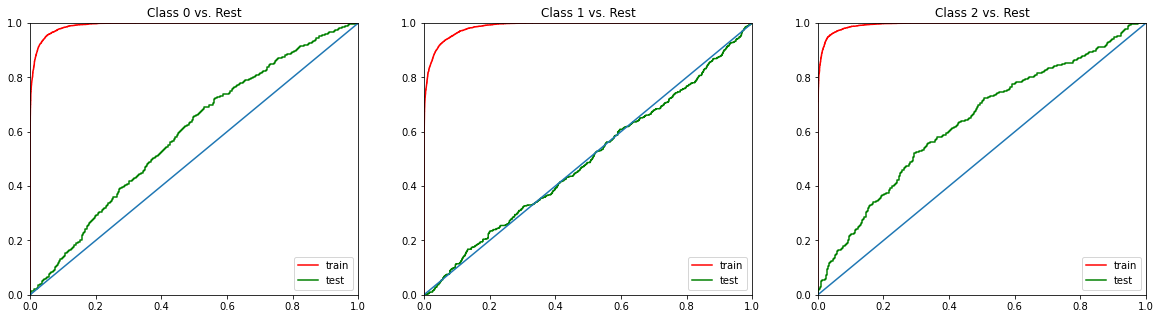

TRAIN dates: 2017-03-12 08:00:00 - 2019-07-24 09:01:00  TEST dates: 2019-08-23 08:06:13 - 2019-10-06 11:15:00
train_index.shape : (69762,) test_index.shape : (3808,)
TRAIN pre AGG shape : (69762, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (18717, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.4046981506347656, 'learning_rate': 4.7774216524216525e-05, 'epoch': 0.2670940170940171, 'step': 250}
{'loss': 0.4157096862792969, 'learning_rate': 4.554843304843305e-05, 'epoch': 0.5341880341880342, 'step': 500}
{'loss': 0.4061241455078125, 'learning_rate': 4.332264957264958e-05, 'epoch': 0.8012820512820513, 'step': 750}


Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.3875299072265625, 'learning_rate': 4.10968660968661e-05, 'epoch': 1.0683760683760684, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.969795488008932, 'eval_acc': 0.4180672268907563, 'epoch': 1.0683760683760684, 'step': 1000}
{'loss': 0.356596435546875, 'learning_rate': 3.8871082621082625e-05, 'epoch': 1.3354700854700854, 'step': 1250}
{'loss': 0.3531588134765625, 'learning_rate': 3.664529914529915e-05, 'epoch': 1.6025641025641026, 'step': 1500}
{'loss': 0.359365478515625, 'learning_rate': 3.441951566951567e-05, 'epoch': 1.8696581196581197, 'step': 1750}


Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.325855224609375, 'learning_rate': 3.2193732193732194e-05, 'epoch': 2.1367521367521367, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.94196292745466, 'eval_acc': 0.4721638655462185, 'epoch': 2.1367521367521367, 'step': 2000}
{'loss': 0.299715087890625, 'learning_rate': 2.9967948717948717e-05, 'epoch': 2.4038461538461537, 'step': 2250}
{'loss': 0.298703369140625, 'learning_rate': 2.774216524216524e-05, 'epoch': 2.6709401709401708, 'step': 2500}
{'loss': 0.327552490234375, 'learning_rate': 2.551638176638177e-05, 'epoch': 2.9380341880341883, 'step': 2750}


Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.27290625, 'learning_rate': 2.3290598290598293e-05, 'epoch': 3.2051282051282053, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.3167329862588595, 'eval_acc': 0.4275210084033613, 'epoch': 3.2051282051282053, 'step': 3000}
{'loss': 0.26431201171875, 'learning_rate': 2.1064814814814816e-05, 'epoch': 3.4722222222222223, 'step': 3250}
{'loss': 0.2765302734375, 'learning_rate': 1.883903133903134e-05, 'epoch': 3.7393162393162394, 'step': 3500}


Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.28173486328125, 'learning_rate': 1.6613247863247862e-05, 'epoch': 4.006410256410256, 'step': 3750}
{'loss': 0.22555322265625, 'learning_rate': 1.4387464387464389e-05, 'epoch': 4.273504273504273, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.5255834795847663, 'eval_acc': 0.3960084033613445, 'epoch': 4.273504273504273, 'step': 4000}
{'loss': 0.2414912109375, 'learning_rate': 1.2161680911680912e-05, 'epoch': 4.5405982905982905, 'step': 4250}
{'loss': 0.23349853515625, 'learning_rate': 9.935897435897435e-06, 'epoch': 4.8076923076923075, 'step': 4500}


Iteration:   0%|          | 0/936 [00:00<?, ?it/s]

{'loss': 0.23730419921875, 'learning_rate': 7.71011396011396e-06, 'epoch': 5.0747863247863245, 'step': 4750}
{'loss': 0.20445361328125, 'learning_rate': 5.4843304843304845e-06, 'epoch': 5.3418803418803416, 'step': 5000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.5591836481535135, 'eval_acc': 0.4023109243697479, 'epoch': 5.3418803418803416, 'step': 5000}
{'loss': 0.21531982421875, 'learning_rate': 3.258547008547009e-06, 'epoch': 5.608974358974359, 'step': 5250}
{'loss': 0.21138232421875, 'learning_rate': 1.0327635327635328e-06, 'epoch': 5.8760683760683765, 'step': 5500}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.1101516691826974, 'eval_acc': 0.36712184873949577, 'epoch': 6.0, 'step': 5616}


Prediction:   0%|          | 0/2340 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

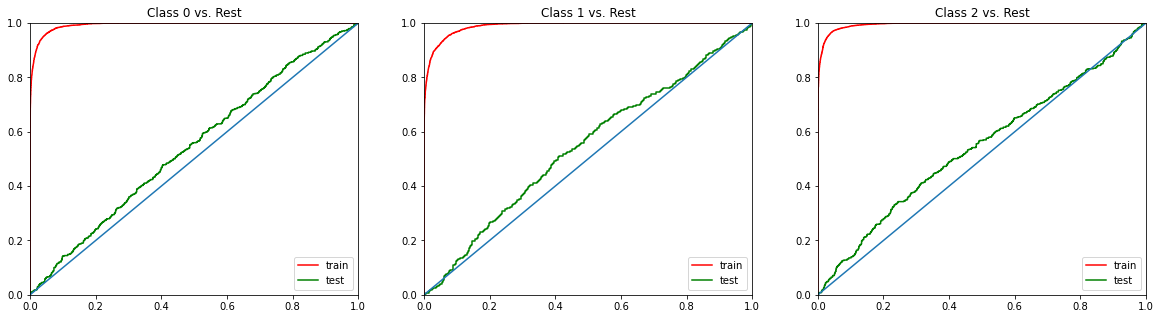

TRAIN dates: 2017-03-12 08:00:00 - 2019-09-09 07:44:17  TEST dates: 2019-10-06 11:15:00 - 2019-11-14 18:04:00
train_index.shape : (73570,) test_index.shape : (3808,)
TRAIN pre AGG shape : (73570, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (19977, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.37202786254882814, 'learning_rate': 4.791458124791459e-05, 'epoch': 0.2502502502502503, 'step': 250}
{'loss': 0.39267630004882814, 'learning_rate': 4.582916249582916e-05, 'epoch': 0.5005005005005005, 'step': 500}
{'loss': 0.42524261474609376, 'learning_rate': 4.374374374374375e-05, 'epoch': 0.7507507507507507, 'step': 750}


Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.4131455078125, 'learning_rate': 4.165832499165833e-05, 'epoch': 1.001001001001001, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.054241155876833, 'eval_acc': 0.36186974789915966, 'epoch': 1.001001001001001, 'step': 1000}
{'loss': 0.3272198486328125, 'learning_rate': 3.957290623957291e-05, 'epoch': 1.2512512512512513, 'step': 1250}
{'loss': 0.3542662353515625, 'learning_rate': 3.7487487487487486e-05, 'epoch': 1.5015015015015014, 'step': 1500}
{'loss': 0.34558837890625, 'learning_rate': 3.540206873540207e-05, 'epoch': 1.7517517517517518, 'step': 1750}


Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.36662890625, 'learning_rate': 3.331664998331665e-05, 'epoch': 2.002002002002002, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.209126338988793, 'eval_acc': 0.36817226890756305, 'epoch': 2.002002002002002, 'step': 2000}
{'loss': 0.289182373046875, 'learning_rate': 3.123123123123123e-05, 'epoch': 2.2522522522522523, 'step': 2250}
{'loss': 0.302734375, 'learning_rate': 2.914581247914581e-05, 'epoch': 2.5025025025025025, 'step': 2500}
{'loss': 0.30754296875, 'learning_rate': 2.7060393727060397e-05, 'epoch': 2.7527527527527527, 'step': 2750}


Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.32755224609375, 'learning_rate': 2.4974974974974976e-05, 'epoch': 3.003003003003003, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.486835019428189, 'eval_acc': 0.3650210084033613, 'epoch': 3.003003003003003, 'step': 3000}
{'loss': 0.2502822265625, 'learning_rate': 2.288955622288956e-05, 'epoch': 3.2532532532532534, 'step': 3250}
{'loss': 0.28280908203125, 'learning_rate': 2.080413747080414e-05, 'epoch': 3.5035035035035036, 'step': 3500}
{'loss': 0.270193359375, 'learning_rate': 1.8718718718718718e-05, 'epoch': 3.7537537537537538, 'step': 3750}


Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.26986474609375, 'learning_rate': 1.66332999666333e-05, 'epoch': 4.004004004004004, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7564232962972977, 'eval_acc': 0.36554621848739494, 'epoch': 4.004004004004004, 'step': 4000}
{'loss': 0.23431298828125, 'learning_rate': 1.4547881214547882e-05, 'epoch': 4.2542542542542545, 'step': 4250}
{'loss': 0.22829296875, 'learning_rate': 1.2462462462462463e-05, 'epoch': 4.504504504504505, 'step': 4500}
{'loss': 0.240998046875, 'learning_rate': 1.0377043710377044e-05, 'epoch': 4.754754754754755, 'step': 4750}


Iteration:   0%|          | 0/999 [00:00<?, ?it/s]

{'loss': 0.24163232421875, 'learning_rate': 8.291624958291625e-06, 'epoch': 5.005005005005005, 'step': 5000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7909722002614448, 'eval_acc': 0.35766806722689076, 'epoch': 5.005005005005005, 'step': 5000}
{'loss': 0.20434765625, 'learning_rate': 6.206206206206207e-06, 'epoch': 5.255255255255255, 'step': 5250}
{'loss': 0.207794921875, 'learning_rate': 4.120787454120788e-06, 'epoch': 5.505505505505505, 'step': 5500}
{'loss': 0.20755322265625, 'learning_rate': 2.035368702035369e-06, 'epoch': 5.7557557557557555, 'step': 5750}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.513291510714202, 'eval_acc': 0.4375, 'epoch': 6.0, 'step': 5994}


Prediction:   0%|          | 0/2498 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

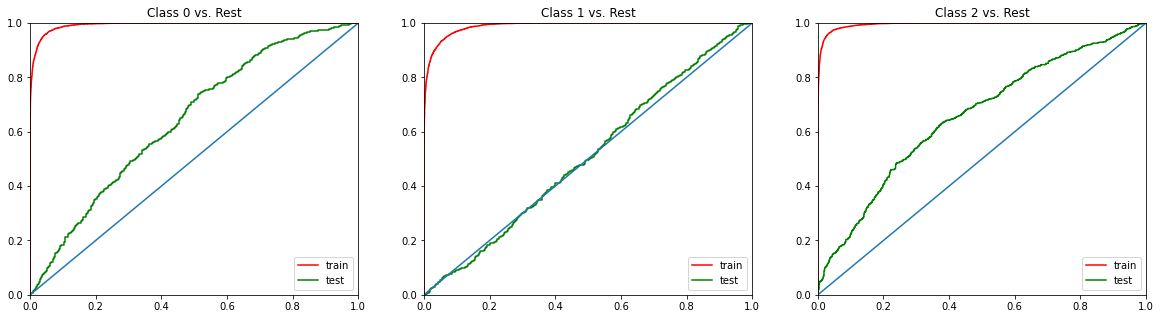

TRAIN dates: 2017-03-12 08:00:00 - 2019-10-21 10:14:00  TEST dates: 2019-11-14 18:04:00 - 2020-01-07 07:58:52
train_index.shape : (77378,) test_index.shape : (3808,)
TRAIN pre AGG shape : (77378, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (21051, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.38358560180664064, 'learning_rate': 4.802152579930358e-05, 'epoch': 0.23741690408357075, 'step': 250}
{'loss': 0.3933454284667969, 'learning_rate': 4.6043051598607155e-05, 'epoch': 0.4748338081671415, 'step': 500}
{'loss': 0.394483642578125, 'learning_rate': 4.406457739791073e-05, 'epoch': 0.7122507122507122, 'step': 750}
{'loss': 0.41409033203125, 'learning_rate': 4.2086103197214313e-05, 'epoch': 0.949667616334283, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.9607642698688668, 'eval_acc': 0.40913865546218486, 'epoch': 0.949667616334283, 'step': 1000}


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.3289940185546875, 'learning_rate': 4.010762899651789e-05, 'epoch': 1.1870845204178537, 'step': 1250}
{'loss': 0.331919677734375, 'learning_rate': 3.8129154795821466e-05, 'epoch': 1.4245014245014245, 'step': 1500}
{'loss': 0.344498046875, 'learning_rate': 3.615068059512504e-05, 'epoch': 1.6619183285849952, 'step': 1750}
{'loss': 0.351540771484375, 'learning_rate': 3.417220639442862e-05, 'epoch': 1.899335232668566, 'step': 2000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.0821545160367707, 'eval_acc': 0.4254201680672269, 'epoch': 1.899335232668566, 'step': 2000}


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.326675048828125, 'learning_rate': 3.2193732193732194e-05, 'epoch': 2.1367521367521367, 'step': 2250}
{'loss': 0.2833896484375, 'learning_rate': 3.0215257993035773e-05, 'epoch': 2.3741690408357075, 'step': 2500}
{'loss': 0.30112646484375, 'learning_rate': 2.823678379233935e-05, 'epoch': 2.611585944919278, 'step': 2750}
{'loss': 0.300726318359375, 'learning_rate': 2.6258309591642926e-05, 'epoch': 2.849002849002849, 'step': 3000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.285401362518803, 'eval_acc': 0.4206932773109244, 'epoch': 2.849002849002849, 'step': 3000}


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.30347900390625, 'learning_rate': 2.4279835390946505e-05, 'epoch': 3.0864197530864197, 'step': 3250}
{'loss': 0.24036962890625, 'learning_rate': 2.230136119025008e-05, 'epoch': 3.3238366571699904, 'step': 3500}
{'loss': 0.26582080078125, 'learning_rate': 2.0322886989553657e-05, 'epoch': 3.561253561253561, 'step': 3750}
{'loss': 0.270134765625, 'learning_rate': 1.8344412788857233e-05, 'epoch': 3.798670465337132, 'step': 4000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.4422468485451545, 'eval_acc': 0.40808823529411764, 'epoch': 3.798670465337132, 'step': 4000}


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.264021484375, 'learning_rate': 1.6365938588160813e-05, 'epoch': 4.036087369420703, 'step': 4250}
{'loss': 0.21685546875, 'learning_rate': 1.4387464387464389e-05, 'epoch': 4.273504273504273, 'step': 4500}
{'loss': 0.21566748046875, 'learning_rate': 1.2408990186767965e-05, 'epoch': 4.510921177587845, 'step': 4750}
{'loss': 0.23920263671875, 'learning_rate': 1.0430515986071541e-05, 'epoch': 4.748338081671415, 'step': 5000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7281269170030824, 'eval_acc': 0.39968487394957986, 'epoch': 4.748338081671415, 'step': 5000}
{'loss': 0.23854150390625, 'learning_rate': 8.452041785375119e-06, 'epoch': 4.985754985754986, 'step': 5250}


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'loss': 0.19096142578125, 'learning_rate': 6.473567584678696e-06, 'epoch': 5.223171889838556, 'step': 5500}
{'loss': 0.202701171875, 'learning_rate': 4.495093383982273e-06, 'epoch': 5.460588793922128, 'step': 5750}
{'loss': 0.1922802734375, 'learning_rate': 2.51661918328585e-06, 'epoch': 5.698005698005698, 'step': 6000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.7946016080364458, 'eval_acc': 0.40913865546218486, 'epoch': 5.698005698005698, 'step': 6000}
{'loss': 0.2064150390625, 'learning_rate': 5.38144982589427e-07, 'epoch': 5.935422602089269, 'step': 6250}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 2.8241124798019395, 'eval_acc': 0.39233193277310924, 'epoch': 6.0, 'step': 6318}


Prediction:   0%|          | 0/2632 [00:00<?, ?it/s]

Prediction:   0%|          | 0/238 [00:00<?, ?it/s]

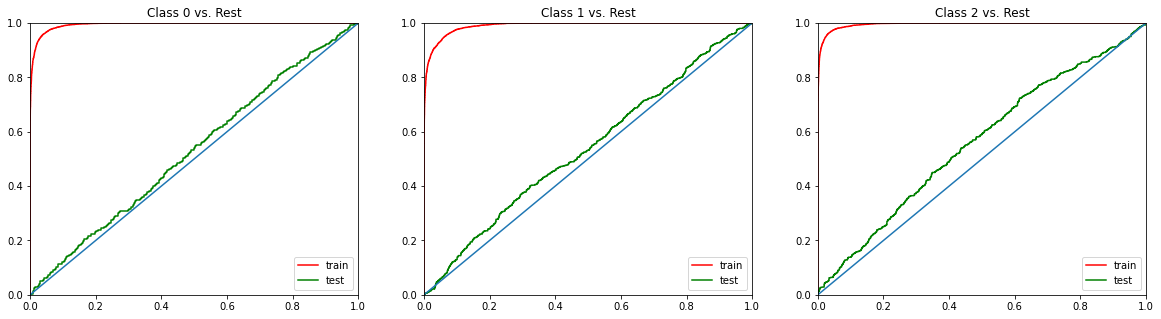

TRAIN dates: 2017-03-12 08:00:00 - 2019-11-28 12:18:00  TEST dates: 2020-01-07 09:53:00 - 2020-02-17 17:55:00
train_index.shape : (81186,) test_index.shape : (3808,)
TRAIN pre AGG shape : (81186, 18)  VAL shape : (1904, 18)  TEST shape : (1904, 18) 
TRAIN shape : (22163, 15)  VAL shape : (1904, 15)  TEST shape : (1904, 15) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1109 [00:00<?, ?it/s]

{'loss': 0.34492901611328125, 'learning_rate': 4.8121430718364894e-05, 'epoch': 0.2254283137962128, 'step': 250}
{'loss': 0.3640166015625, 'learning_rate': 4.624286143672979e-05, 'epoch': 0.4508566275924256, 'step': 500}
{'loss': 0.37949835205078125, 'learning_rate': 4.436429215509468e-05, 'epoch': 0.6762849413886384, 'step': 750}
{'loss': 0.3978392333984375, 'learning_rate': 4.2485722873459575e-05, 'epoch': 0.9017132551848512, 'step': 1000}


Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 1.6226348554512031, 'eval_acc': 0.49842436974789917, 'epoch': 0.9017132551848512, 'step': 1000}


Iteration:   0%|          | 0/1109 [00:00<?, ?it/s]

{'loss': 0.354558349609375, 'learning_rate': 4.060715359182447e-05, 'epoch': 1.127141568981064, 'step': 1250}


In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=int(GAP))
print(tscv)
acc = []
fold = 0

for train_index, test_index in tscv.split(features):
  torch.cuda.empty_cache()
  fold = fold + 1
  print(f"TRAIN dates: {features.iloc[train_index[0]].date} - {features.iloc[train_index[-1]].date}  TEST dates: {features.iloc[test_index[0]].date} - {features.iloc[test_index[-1]].date}") 
  
  print(f"train_index.shape : {train_index.shape} test_index.shape : {test_index.shape}")
  # train_split = int(train_index.shape[0]*0.8)  
  train = features.iloc[train_index]  
  val = features.iloc[test_index[0:int(test_index.shape[0]/2)]]
  test = features.iloc[test_index[int(test_index.shape[0]/2):]]
  
  print(f"TRAIN pre AGG shape : {train.shape}  VAL shape : {val.shape}  TEST shape : {test.shape} ")

  train['date_agg'] = train.date.dt.date
  # # #Nos quedamos con las noticias que han publicado solamente 1 vez en el dia en el mismo media para un ticker para evitar noticias contradictorias
  df_grpby = train.groupby(['date_agg','ticker','resource'])
  df_agg = df_grpby.agg({'ticker':'count'})
  df_agg = df_agg[df_agg.ticker==1]
  train = pd.merge(train, df_agg,  how='inner', left_on=['date_agg','ticker','resource'], right_index=True)
  train.drop('ticker_x', axis=1, inplace=True)
  train.drop('date_agg', axis=1, inplace=True)
  train.drop('ticker_y', axis=1, inplace=True)
  
  train.drop(["date", "ticker","resource"], axis=1, inplace=True)
  val.drop(["date", "ticker","resource"], axis=1, inplace=True)
  test.drop(["date", "ticker","resource"], axis=1, inplace=True)

  print(f"TRAIN shape : {train.shape}  VAL shape : {val.shape}  TEST shape : {test.shape} ")
  # if train.shape[0]<1000:
  #   continue

  ss = StandardScaler()
  train[to_standardize] = ss.fit_transform(train[to_standardize])
  val[to_standardize] = ss.transform(val[to_standardize])
  test[to_standardize] = ss.transform(test[to_standardize])

#   train.to_csv(f"tfm/inputs/{fold}/train.csv")
#   test.to_csv(f"tfm/inputs/{fold}/test.csv")
#   val.to_csv(f"tfm/inputs/{fold}/val.csv")

#   train_dataset, val_dataset, test_dataset = load_data_from_folder(
#       f"{data_args.data_path}/{fold}",
#       data_args.column_info['text_cols'],
#       tokenizer,
#       label_col=data_args.column_info['label_col'],
#       categorical_cols=data_args.column_info['cat_cols'],
#       numerical_cols=data_args.column_info['num_cols'],
#       sep_text_token_str=tokenizer.sep_token,
#       max_token_length=512
#   )
  train_dataset = load_data(
    train,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

  val_dataset = load_data(
    val,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

  test_dataset = load_data(
    test,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
    max_token_length=512)

  training_args = TrainingArguments(
      run_name="vola_paragraphs",
      output_dir=f"tfm/checkpoints/vola_paragraph7/{fold}",
      logging_dir=f"tfm/logs/vola_paragraph7/{fold}",
      overwrite_output_dir=True,
      do_train=True,
      do_eval=True,
      per_device_train_batch_size=20,
      num_train_epochs=N_EPOCAS,
      evaluate_during_training=True,
      logging_steps=250,
      eval_steps=1000,
      save_steps=500,
      save_total_limit=10,
      learning_rate=5e-5,
      seed=42
  )
  
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=calc_classification_metrics,
  )
  _train = trainer.train()

  # evaluación sobre test
  eva = trainer.evaluate(test_dataset)
  eva

  output_train=trainer.predict(train_dataset)
  output_test=trainer.predict(test_dataset)
  proba_train = tf.nn.softmax(output_train.predictions).numpy()
  proba_test = tf.nn.softmax(output_test.predictions).numpy()
  y_predictions_train = proba_train.argmax(axis=1)
  y_predictions_test = proba_test.argmax(axis=1)

  figure, axis = plt.subplots(1, 3, figsize=(20,5))
  for i in range(3):
      train_fpr, train_tpr, train_thr = roc_curve((train.vola_label.values == i).astype("int"), proba_train[:,i], pos_label=1)
      test_fpr, test_tpr, test_thr = roc_curve((test.vola_label.values == i).astype("int"), proba_test[:,i], pos_label=1)
      axis[i].set_title(f"Class {i} vs. Rest")
      axis[i].plot(train_fpr, train_tpr, color='r', label='train')
      axis[i].plot(test_fpr, test_tpr, color='g', label='test')
      axis[i].plot([0,1],[0,1])
      axis[i].axis(xmin=0.0,xmax=1.0, ymin=0.0, ymax=1.0)
      axis[i].legend(loc='lower right')
  plt.show()


  trainer.save_model(f"tfm/checkpoints/vola_paragraph7/trained_model/{fold}")

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "tfm/logs/vola_paragraph7"